In [1]:
import pandas as pd
import pandasql
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import ticker
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
matplotlib.rcParams['figure.dpi'] = 300

from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier 

In [2]:
dataset=pd.read_excel("Sample Data-3.xlsx",sheet_name="datadump")
del(dataset['Unnamed: 0'])
dataset.columns

Index(['playerid', 'install date', 'current level', 'No. of sessions',
       'coin balance', 'No. of spins', 'days before second visit',
       'Total coin wins', 'Total coin bets'],
      dtype='object')

# Data Quality Check

In [3]:
def data_preview(input):
    '''
    Return the feature name, data type, data missing rate, data example, statistics for every columns in a dataframe.
    '''
    # data type
    df = pd.DataFrame(input.dtypes, columns=["dtypes"])
    # missing rate
    df["Null_Rate(%)"] = [round(x,2) for x in list((input.isnull().mean() * 100).values)]
    # data preview first row
    df["Feature_Data_Example"] = input.loc[0].values
    # count, mean, std, min, 25%, 50%, 75%, max
    df = pd.concat([df, input.describe().T], axis=1)
    # set index to number
    df.reset_index(inplace=True)
    df.rename(columns={"index": "feature"}, inplace=True)
    return df.sort_values(by="Null_Rate(%)", ascending=True)

In [4]:
data_preview(dataset)

,feature,dtypes,Null_Rate(%),Feature_Data_Example,count,mean,std,min,25%,50%,75%,max
0,playerid,float64,0.00,4612644347952879616.0,1999.0,5.702213e+18,6.432518e+17,4.612644e+18,5.130660e+18,5.683686e+18,6.250644e+18,6.824722e+18
1,install date,datetime64[ns],0.00,2014-09-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,current level,int64,0.00,10,1999.0,6.445723e+00,5.490180e+00,0.000000e+00,2.000000e+00,6.000000e+00,9.000000e+00,4.500000e+01
3,No. of sessions,int64,0.00,1,1999.0,1.962981e+00,1.992637e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,5.700000e+01
4,coin balance,float64,1.30,62105.0,1973.0,6.242940e+04,2.242560e+05,6.000000e+00,2.600000e+04,2.912500e+04,4.288700e+04,7.210980e+06
5,No. of spins,float64,14.16,112.0,1716.0,2.415624e+02,3.305134e+02,1.000000e+00,5.600000e+01,1.380000e+02,2.970000e+02,3.774000e+03
7,Total coin wins,float64,14.16,117635.0,1716.0,1.373826e+05,6.911344e+05,0.000000e+00,7.503750e+03,2.667750e+04,7.688075e+04,1.835403e+07
8,Total coin bets,float64,14.16,159680.0,1716.0,1.497167e+05,6.780811e+05,4.000000e+01,1.183000e+04,4.184000e+04,1.030800e+05,1.714940e+07
6,days before second visit,float64,40.42,NaN,1191.0,2.078086e+00,2.376308e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.100000e+01


In [5]:
#check if playerid is unique
pandasql.sqldf("SELECT count(*),count(distinct playerid) FROM dataset")

,count(*),count(distinct playerid)
0,1999,1999


# Explorative Data Analysis

## User Growth: New users appear to be normally distributed over the time window

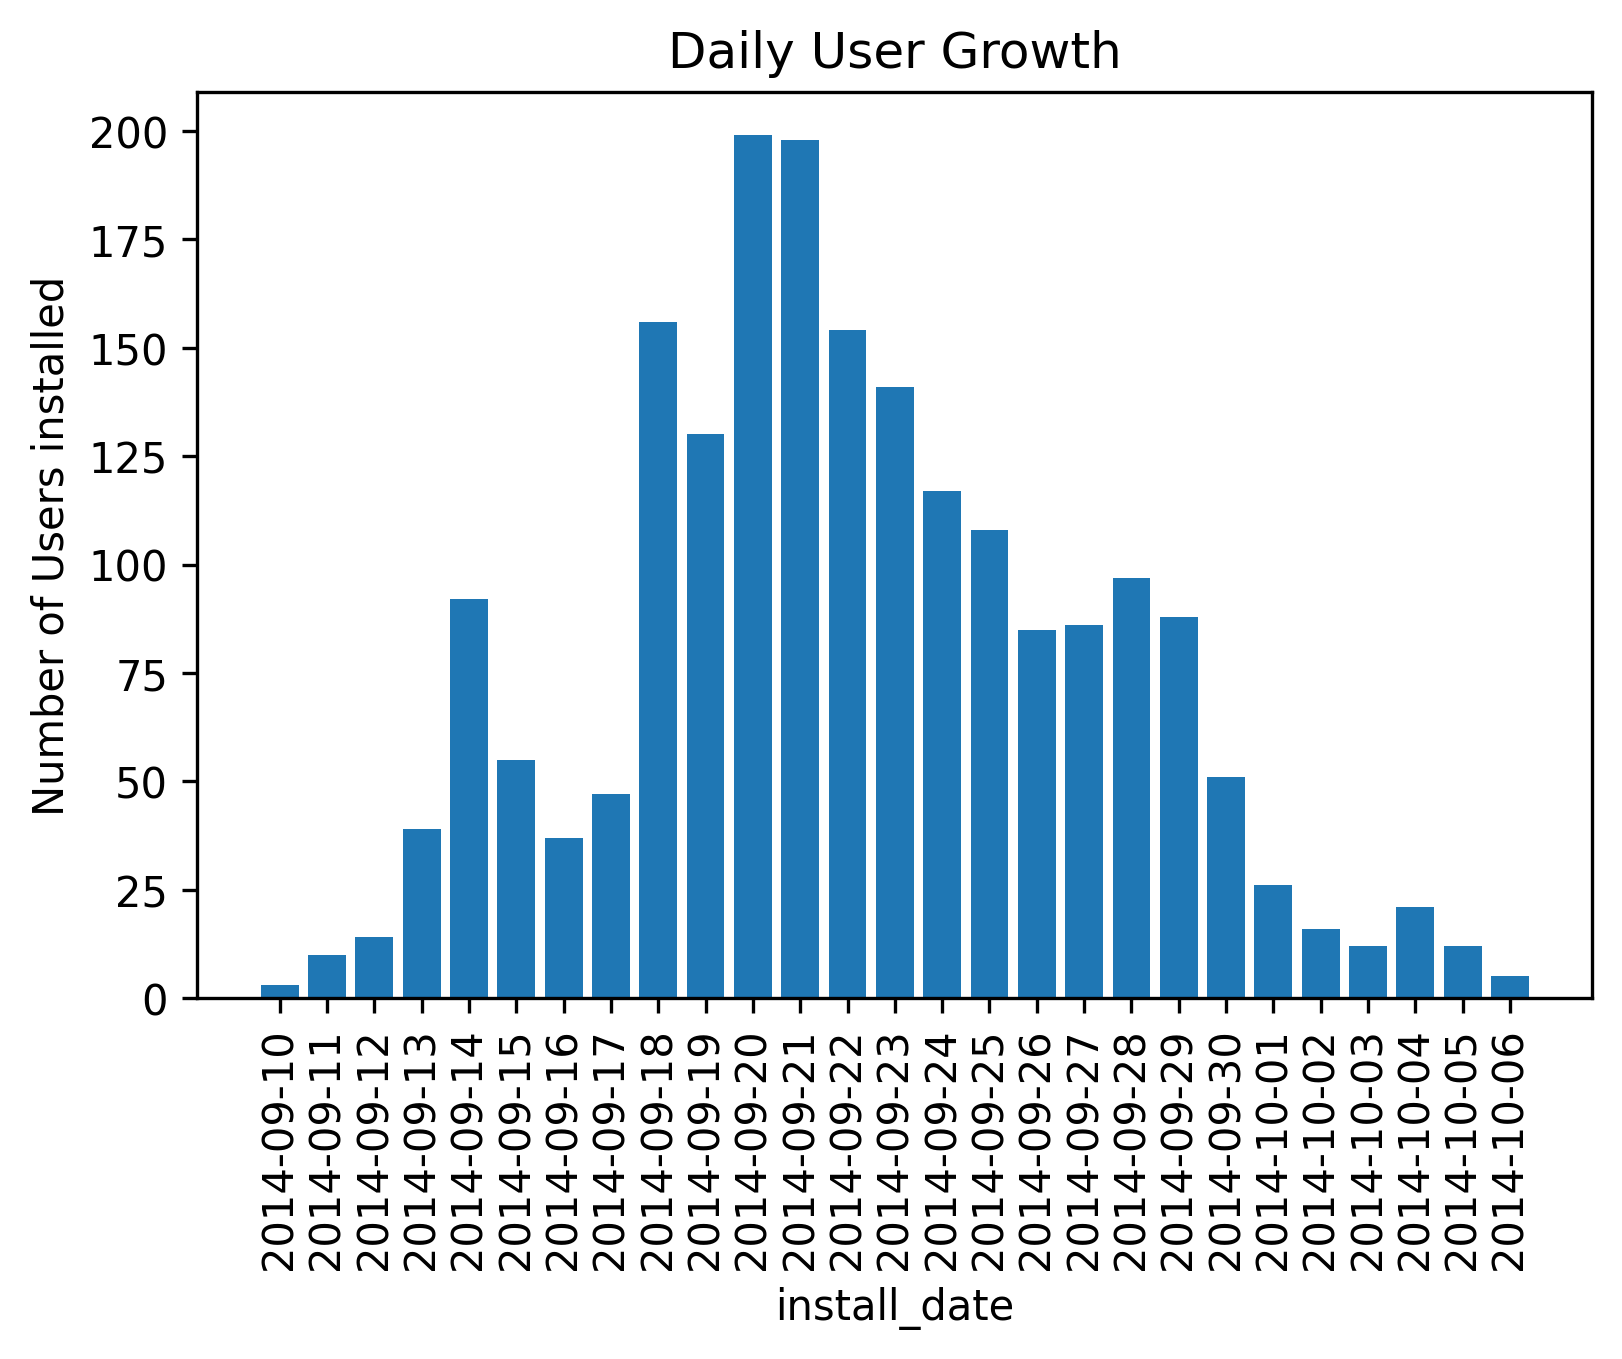

In [6]:
sql="""
SELECT 
    STRFTIME('%Y-%m-%d', "install date") AS install_date,
    count(*) AS install_quantity 
FROM dataset
GROUP BY STRFTIME('%Y-%m-%d', "install date")
ORDER BY "install date" ASC
"""
temp_df_1=pandasql.sqldf(sql)

plt.bar(x=temp_df_1['install_date'],height=temp_df_1['install_quantity'])
plt.xticks(rotation = 90)
plt.xlabel("install_date")
plt.ylabel("Number of Users installed")
plt.title("Daily User Growth")
plt.show()

## Percentage of Second Visit: The Re-visit Rate in the following days after install are 41%, 7%, 3%, 2%, 2%, 2%. After 6 days,  Re-visit Rate becomes lower than 1%.
## For the following analysis, focus on the Re-visit Rate within 3 days.

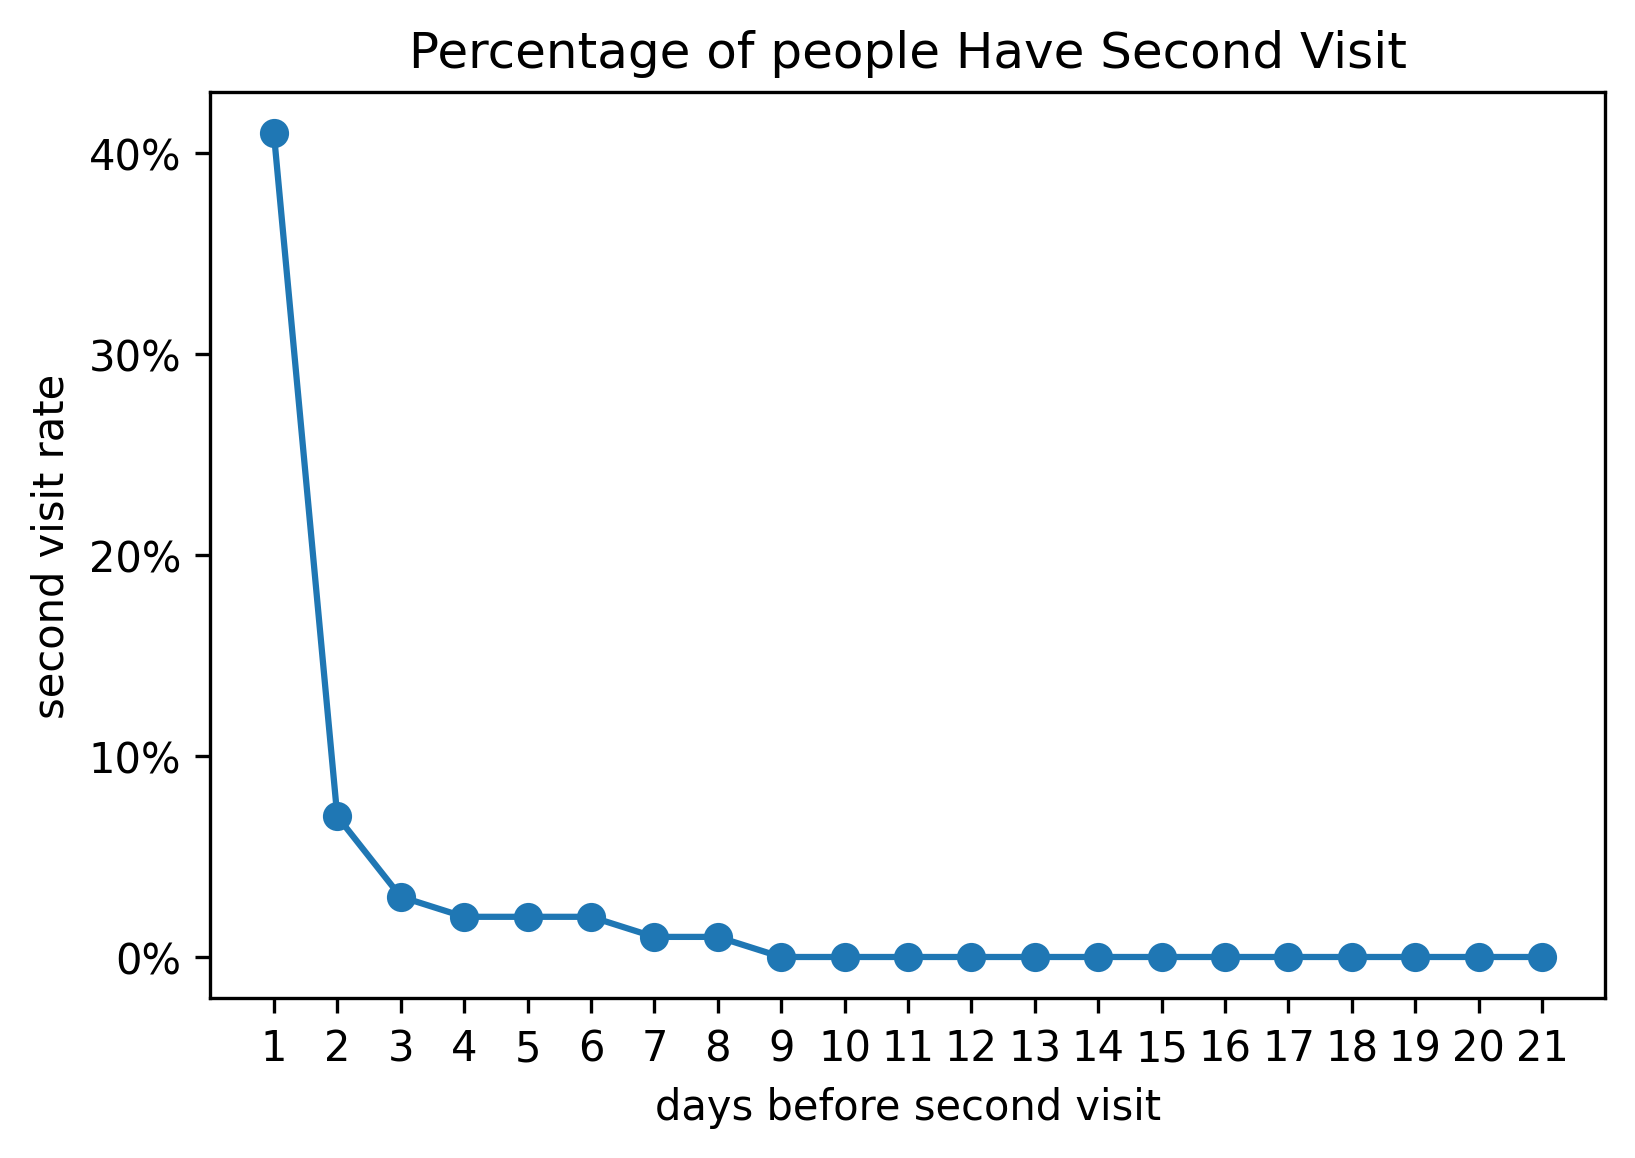

In [7]:
sql="""
WITH RECURSIVE cte("days before second visit") AS(
    SELECT 1 
    UNION ALL 
    SELECT "days before second visit"+1 FROM cte
    WHERE "days before second visit"<(SELECT MAX("days before second visit") FROM dataset)
)
,revisit_pivot AS(
    SELECT 
        "days before second visit",
        ROUND(COUNT(*)/{}.,2) AS "revisit_rate"
    FROM dataset
    WHERE "days before second visit"<>'NaN'
    GROUP BY "days before second visit"
)
SELECT 
    CAST(cte."days before second visit" AS TEXT) AS "days before second visit",
    COALESCE(revisit_pivot."revisit_rate",0) as revisit_rate
FROM cte
LEFT JOIN revisit_pivot
ON cte."days before second visit"=revisit_pivot."days before second visit"
""".format(len(dataset))
temp_df_2=pandasql.sqldf(sql)

plt.plot(temp_df_2['days before second visit'],temp_df_2['revisit_rate'],'o-')
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
plt.xlabel("days before second visit")
plt.ylabel("second visit rate")
plt.title("Percentage of people Have Second Visit")
plt.show()

## From time perspective, the trend of percentage of re-visit within 3 days after install keep decreasing.
### Possible Insights: In the early days, the proportion of natural growth users was high, and these users themselves were very interested in the game, so the user stickiness was high at the early days.
### Possible Insights:There are problems with the game itself, and the problems are gradually revealed over time, such as this is not a fair slot game.
### Possible Insights: In addition to the trend, there are certain regular fluctuations of the 3 days re-visit rate, which may be caused by the weekend effect.

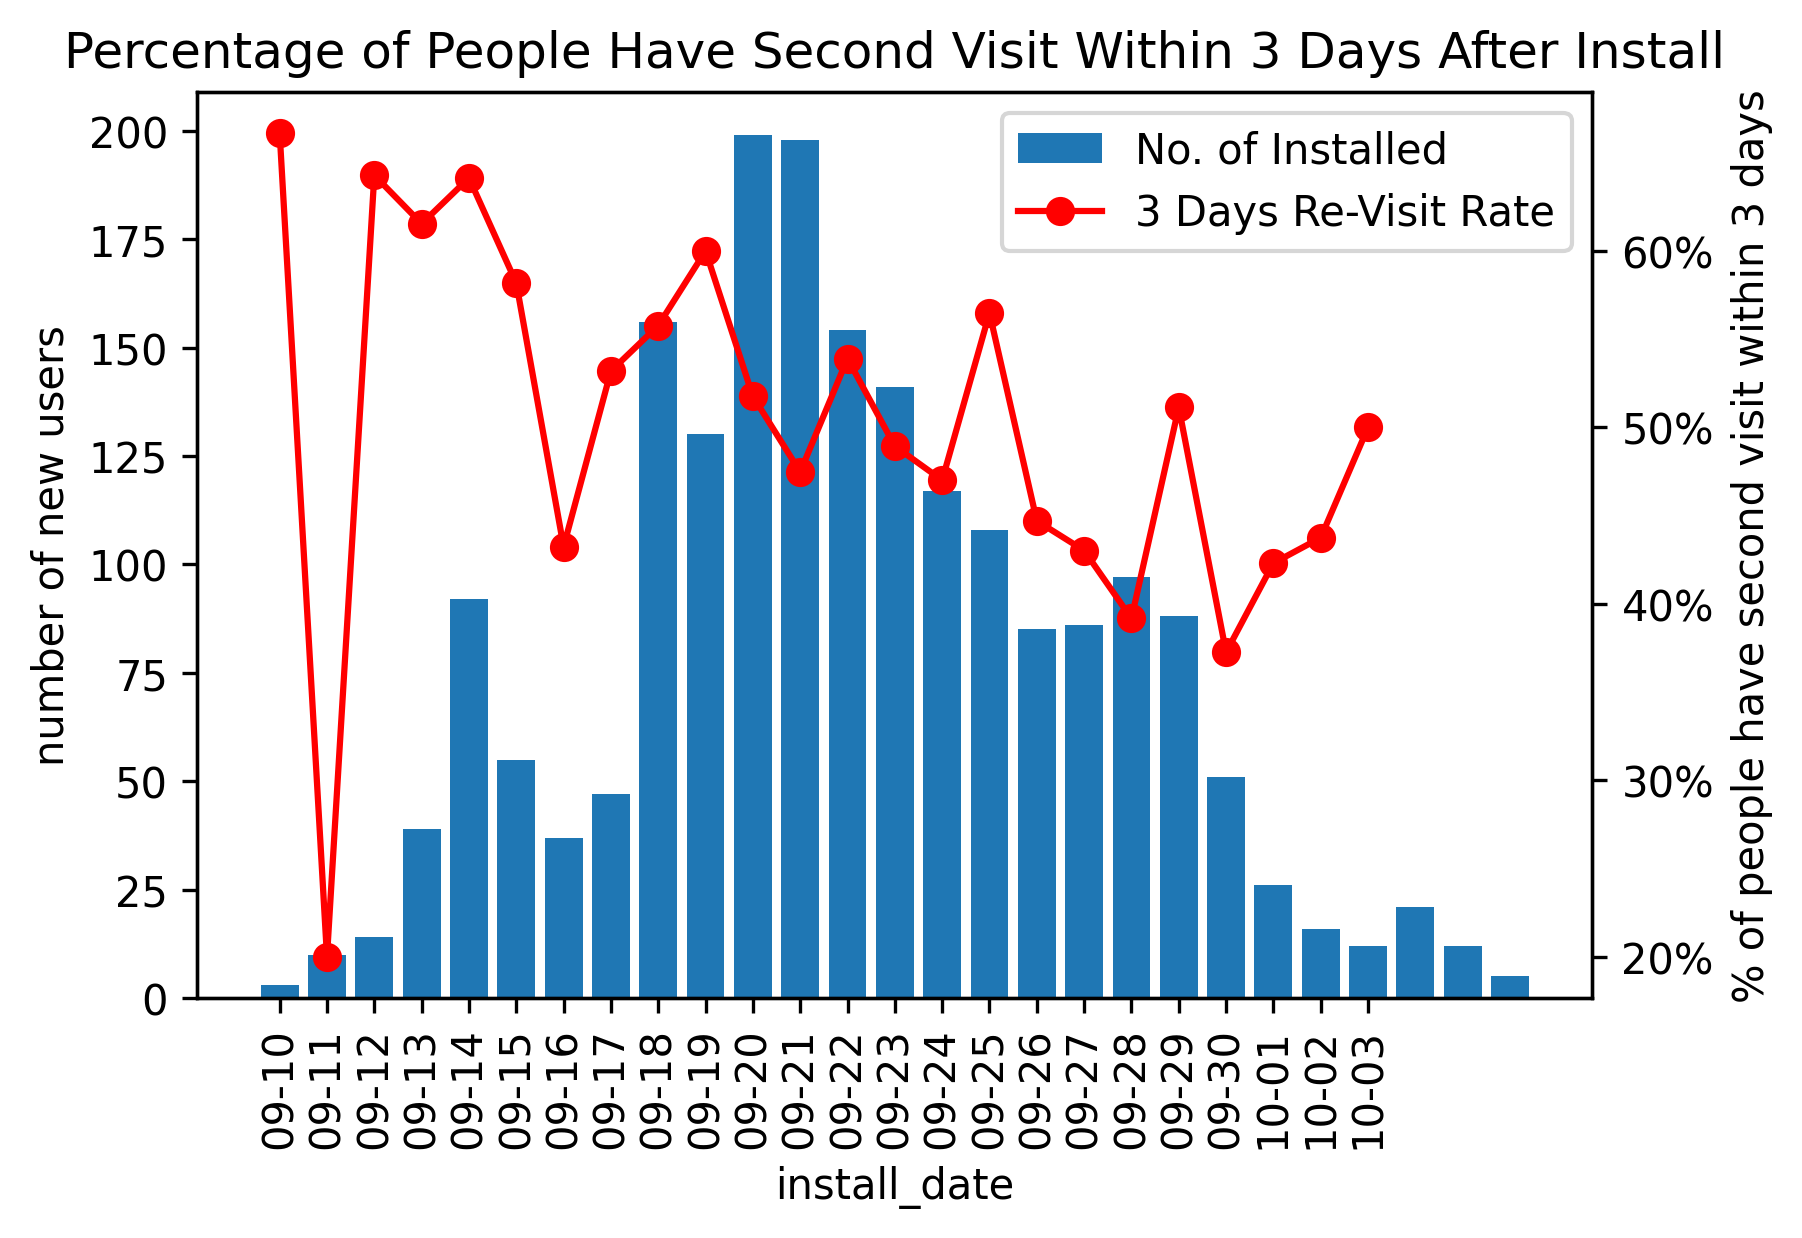

In [8]:
sql="""
SELECT
    STRFTIME('%m-%d', "install date") AS install_date,
    CAST(COUNT(CASE WHEN "days before second visit" IN (1, 2, 3) THEN 1 ELSE NULL END) AS FLOAT)/COUNT(*) as "% of revisit within 3 days"
FROM dataset
WHERE "install date"<'2014-10-04'
GROUP BY "install date" 
ORDER BY "install date"
"""
temp_df_3=pandasql.sqldf(sql)

fig, ax1 = plt.subplots()
p1=ax1.bar(x=temp_df_1['install_date'],height=temp_df_1['install_quantity'],label='No. of Installed')
ax2 = ax1.twinx()
p2=ax2.plot(temp_df_3['install_date'],temp_df_3['% of revisit within 3 days'],'o-',color='red',label="3 Days Re-Visit Rate")

plt.setp(ax1.xaxis.get_majorticklabels(),rotation=90)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax1.set_xlabel("install_date")
ax1.set_ylabel("number of new users")
ax2.set_ylabel("% of people have second visit within 3 days")
plt.title("Percentage of People Have Second Visit Within 3 Days After Install")
fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

## No. of sessions

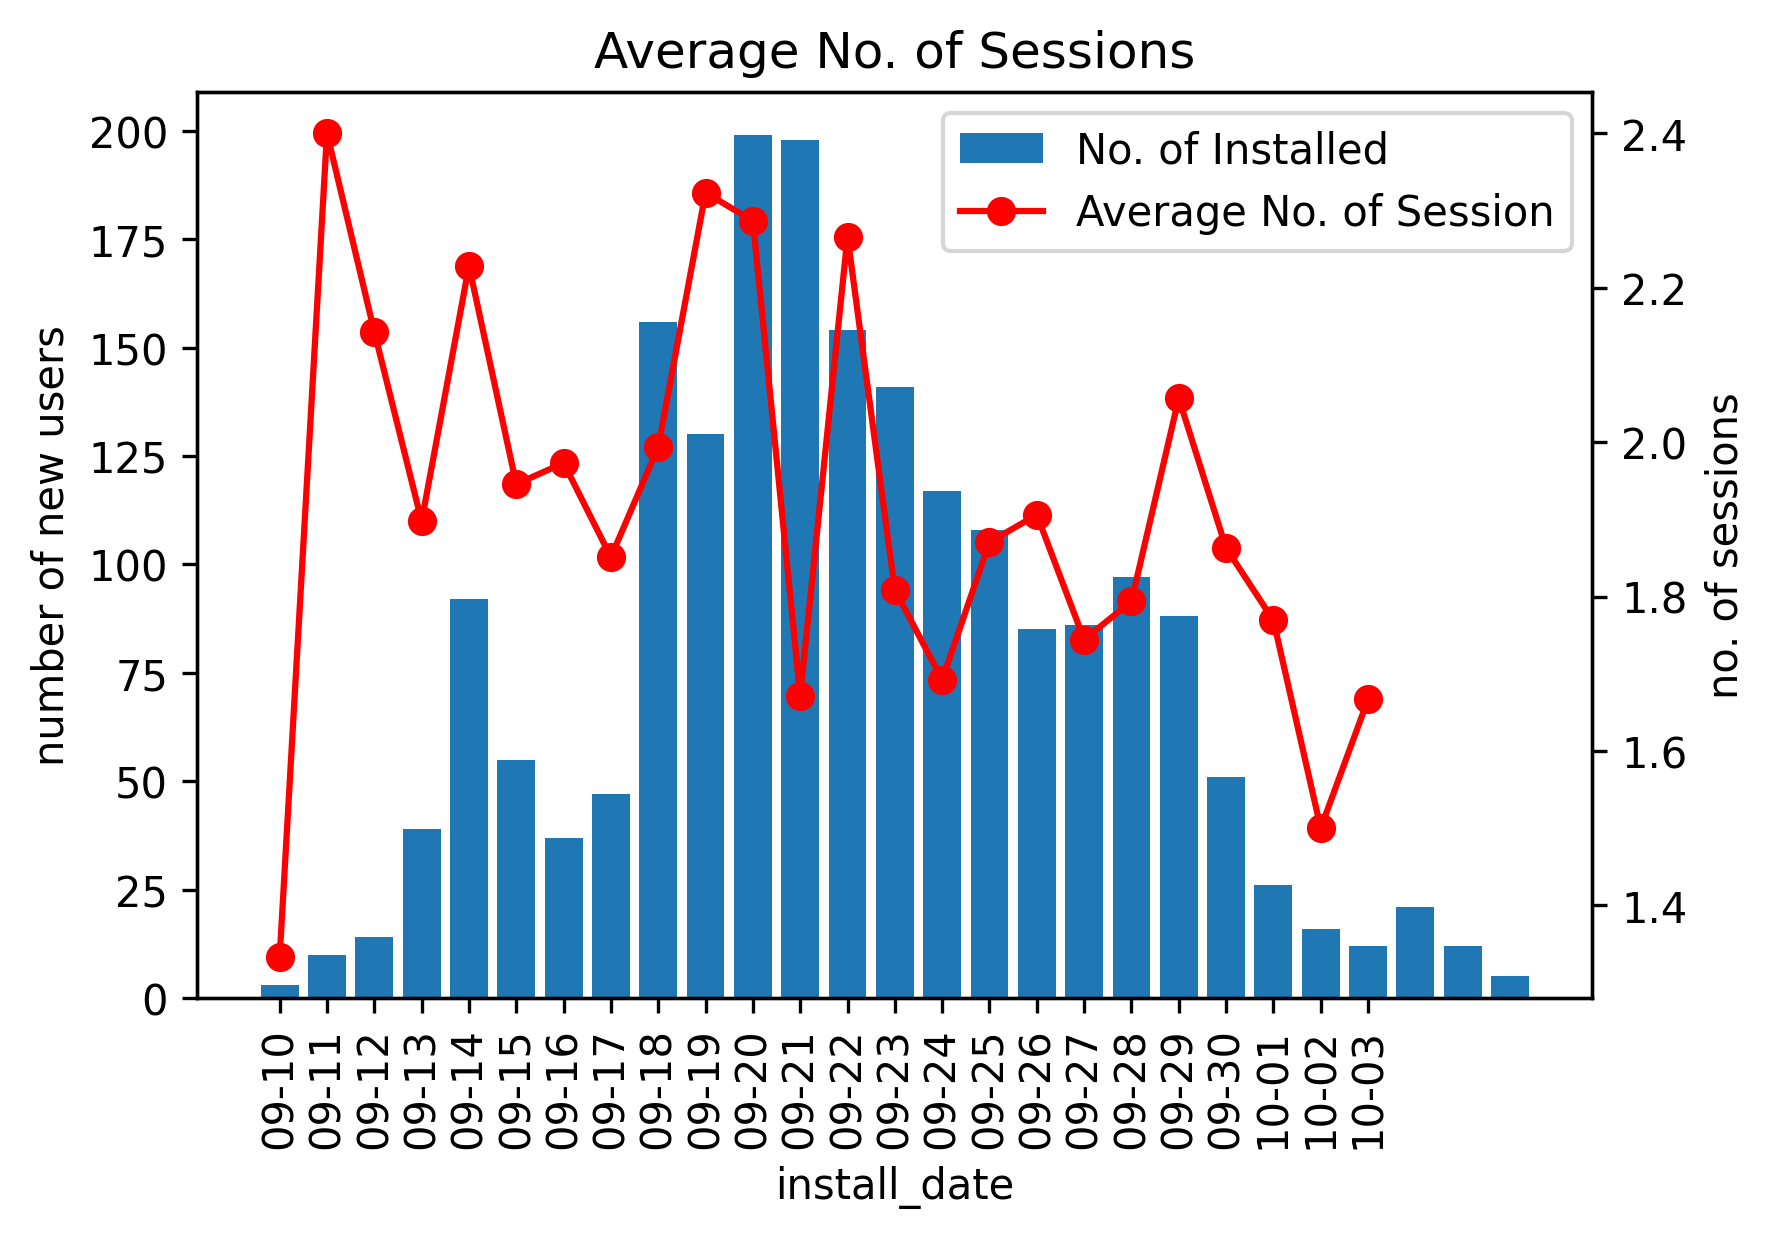

In [9]:
sql="""
SELECT
    STRFTIME('%m-%d', "install date") AS install_date,
    AVG("No. of sessions") as "average no. of sessions"
FROM dataset
WHERE "install date"<'2014-10-04'
GROUP BY "install date" 
ORDER BY "install date"
"""
temp_df_3=pandasql.sqldf(sql)

fig, ax1 = plt.subplots()
ax1.bar(x=temp_df_1['install_date'],height=temp_df_1['install_quantity'],label='No. of Installed')
ax2 = ax1.twinx()
ax2.plot(temp_df_3['install_date'],temp_df_3['average no. of sessions'],'o-',color='red',label="Average No. of Session")

plt.setp(ax1.xaxis.get_majorticklabels(),rotation=90)
ax1.set_xlabel("install_date")
ax1.set_ylabel("number of new users")
ax2.set_ylabel("no. of sessions")
plt.title("Average No. of Sessions")
fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

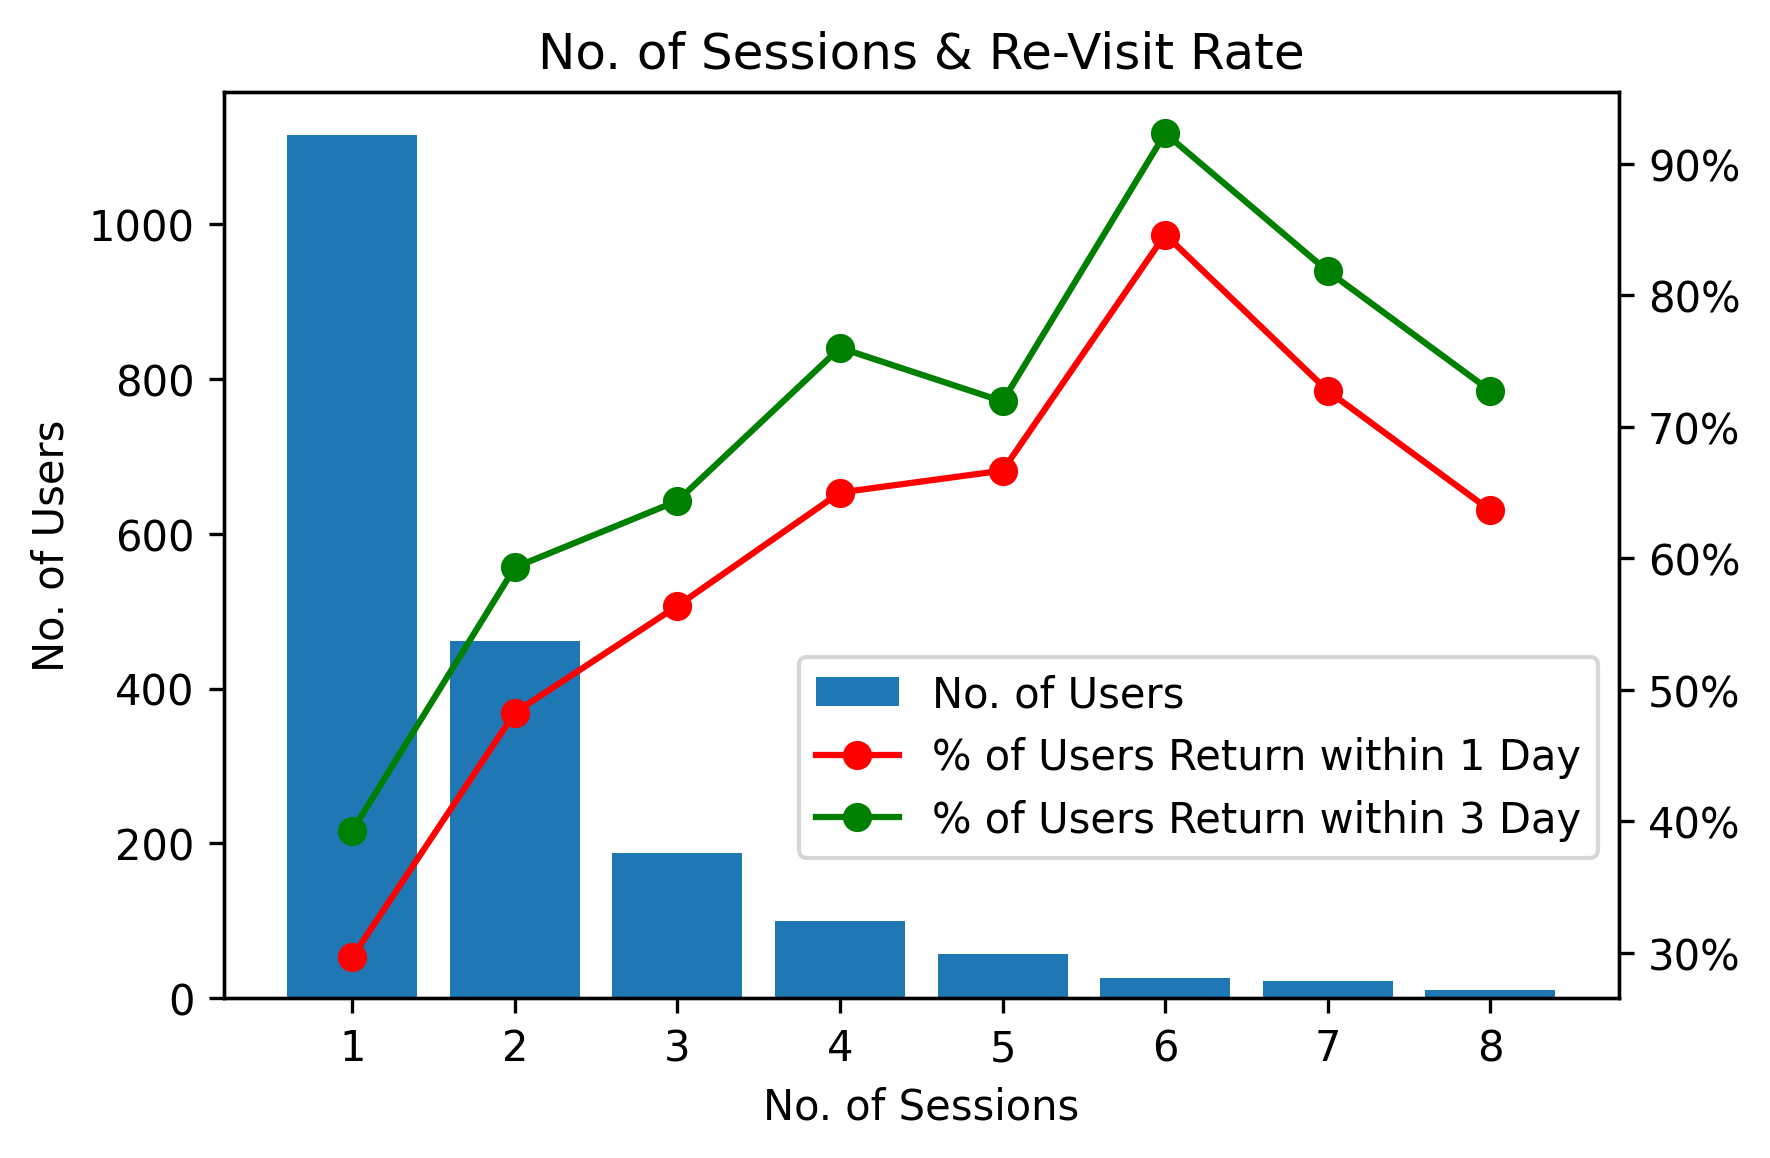

In [10]:
sql="""
SELECT
    "No. of sessions",
    COUNT(*) as "No. of Users",
    COUNT(CASE WHEN "days before second visit" IN (1) THEN 1 ELSE NULL END),
    COUNT(CASE WHEN "days before second visit" IN (1, 2, 3) THEN 1 ELSE NULL END),
    CAST(COUNT(CASE WHEN "days before second visit" IN (1) THEN 1 ELSE NULL END) AS FLOAT)/COUNT(*) AS "% of Users Return within 1 Day",
    CAST(COUNT(CASE WHEN "days before second visit" IN (1, 2, 3) THEN 1 ELSE NULL END) AS FLOAT)/COUNT(*) AS "% of Users Return within 3 Day"
FROM dataset
GROUP BY "No. of sessions"
HAVING COUNT(*)>10
"""
temp_df_4=pandasql.sqldf(sql)
fig, ax1 = plt.subplots()
ax1.bar(x=temp_df_4['No. of sessions'],height=temp_df_4['No. of Users'],label='No. of Users')
ax2 = ax1.twinx()
ax2.plot(temp_df_4['No. of sessions'],temp_df_4['% of Users Return within 1 Day'],'o-',color='red',label='% of Users Return within 1 Day')
ax2.plot(temp_df_4['No. of sessions'],temp_df_4['% of Users Return within 3 Day'],'o-',color='green',label='% of Users Return within 3 Day')
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax1.set_ylabel("No. of Users")
ax1.set_xlabel("No. of Sessions")
plt.title("No. of Sessions & Re-Visit Rate")
fig.legend(bbox_to_anchor=(1,0.4), bbox_transform=ax1.transAxes)
plt.show()

## Bet yield rate
### By calculating the weighted average of "Bet yield rate" with "Total coin wins" as the weight, I find out that the Expected Bet yield rate is -14%.

$$Bet\,yield\,rate_i=\frac{Total\,coin\,wins_i-\,Total\,coin\,bets_i}{Total\,coin\,bets_i}$$

$$Expected\,Bet\,yield\,rate\,=\,\frac{\displaystyle \sum{No.\,of\,spins\times Bet\,yield\,rate}}{\displaystyle \sum{No.\,of\,spins}}=-14\%$$

### Conclusion: This is not a fair game, so it's hard to maintain user retention in the long run.

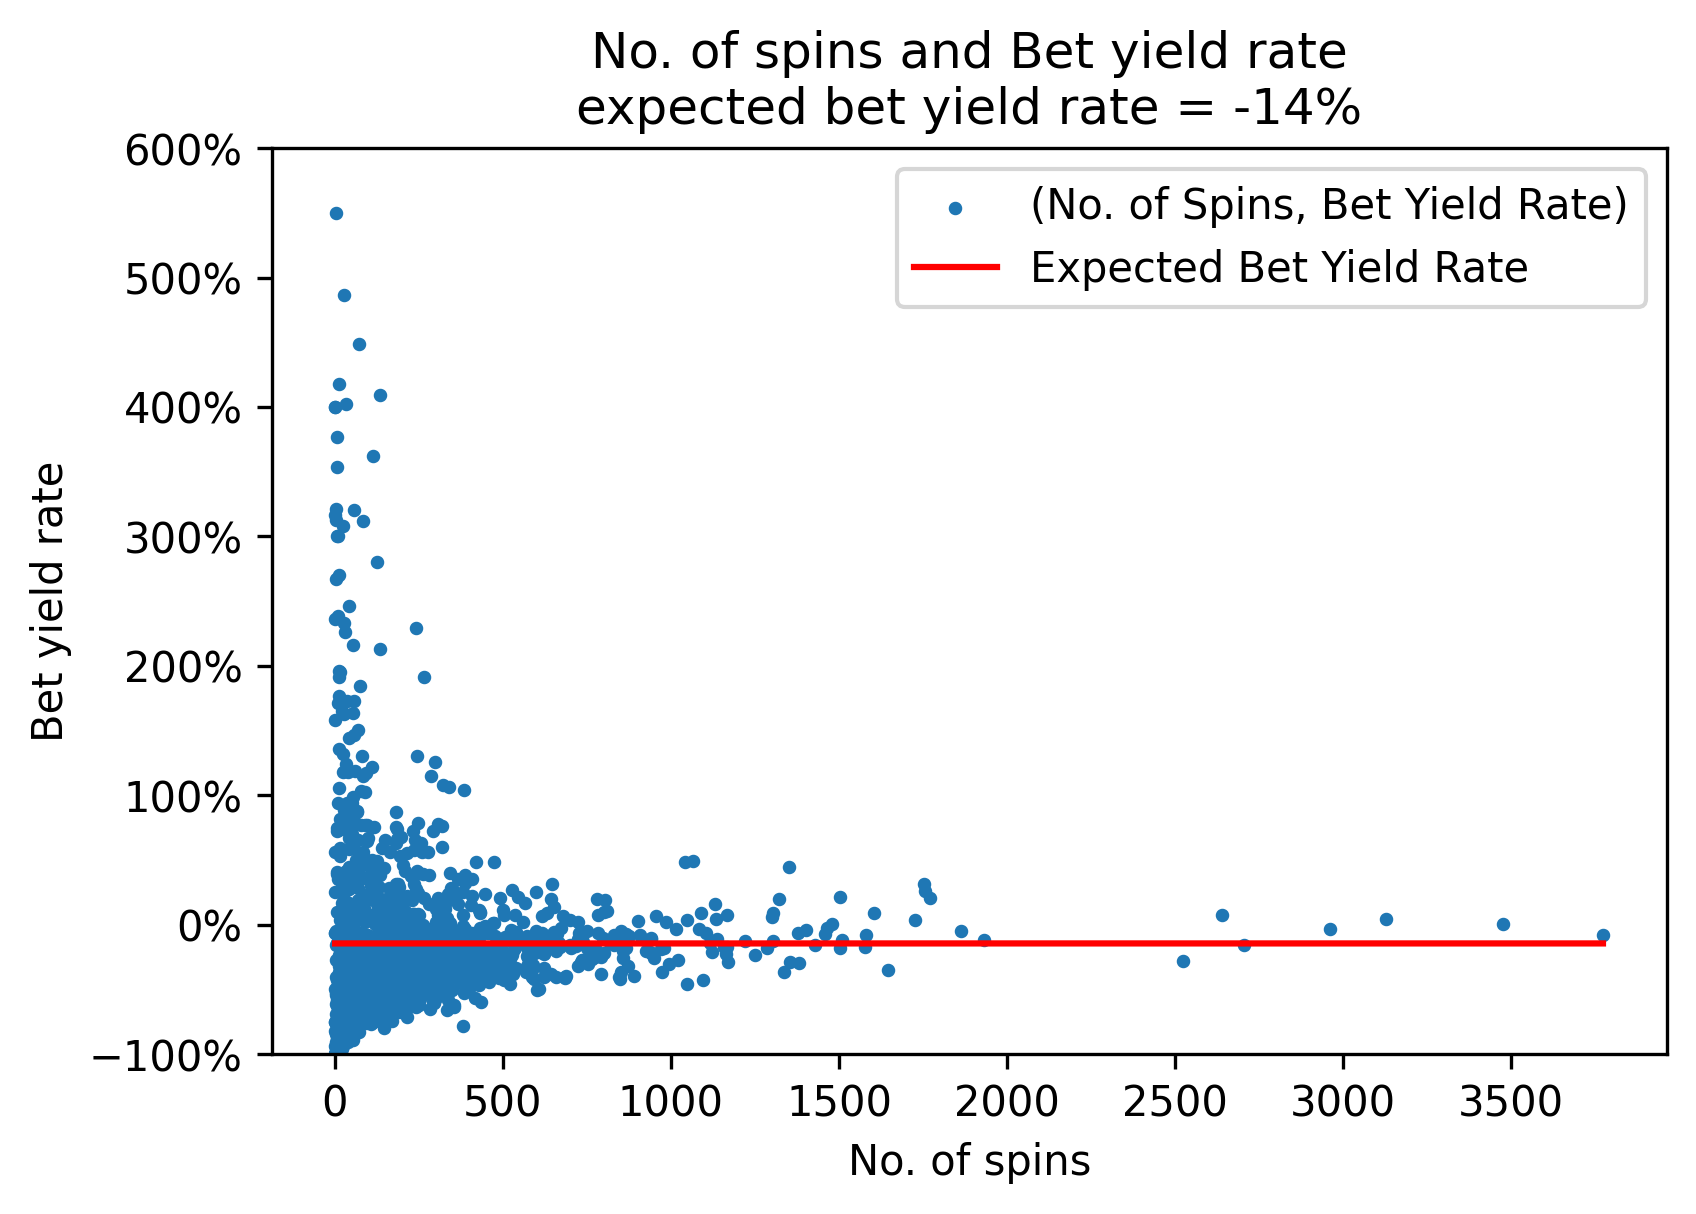

In [11]:
dataset['Bet yield rate']=dataset['Total coin wins']/dataset['Total coin bets']-1

sql="""
SELECT
    SUM("No. of spins"*"Bet yield rate")/SUM("No. of spins")
FROM dataset
WHERE "No. of spins" IS NOT Null
"""
expected_bet_yield_rate=pandasql.sqldf(sql).values[0][0]
fig, ax1 = plt.subplots()
ax1.scatter(x=dataset['No. of spins'],y=dataset['Bet yield rate'],s=5,label="(No. of Spins, Bet Yield Rate)")
ax1.plot(range(1,int(dataset['No. of spins'].max())),[expected_bet_yield_rate for _ in range(1,int(dataset['No. of spins'].max()))],color='r',label="Expected Bet Yield Rate")

plt.ylim(-1,6)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
plt.xlabel('No. of spins')
plt.ylabel('Bet yield rate')
plt.title("No. of spins and Bet yield rate\nexpected bet yield rate = {}%".format(int(expected_bet_yield_rate*100)))
fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

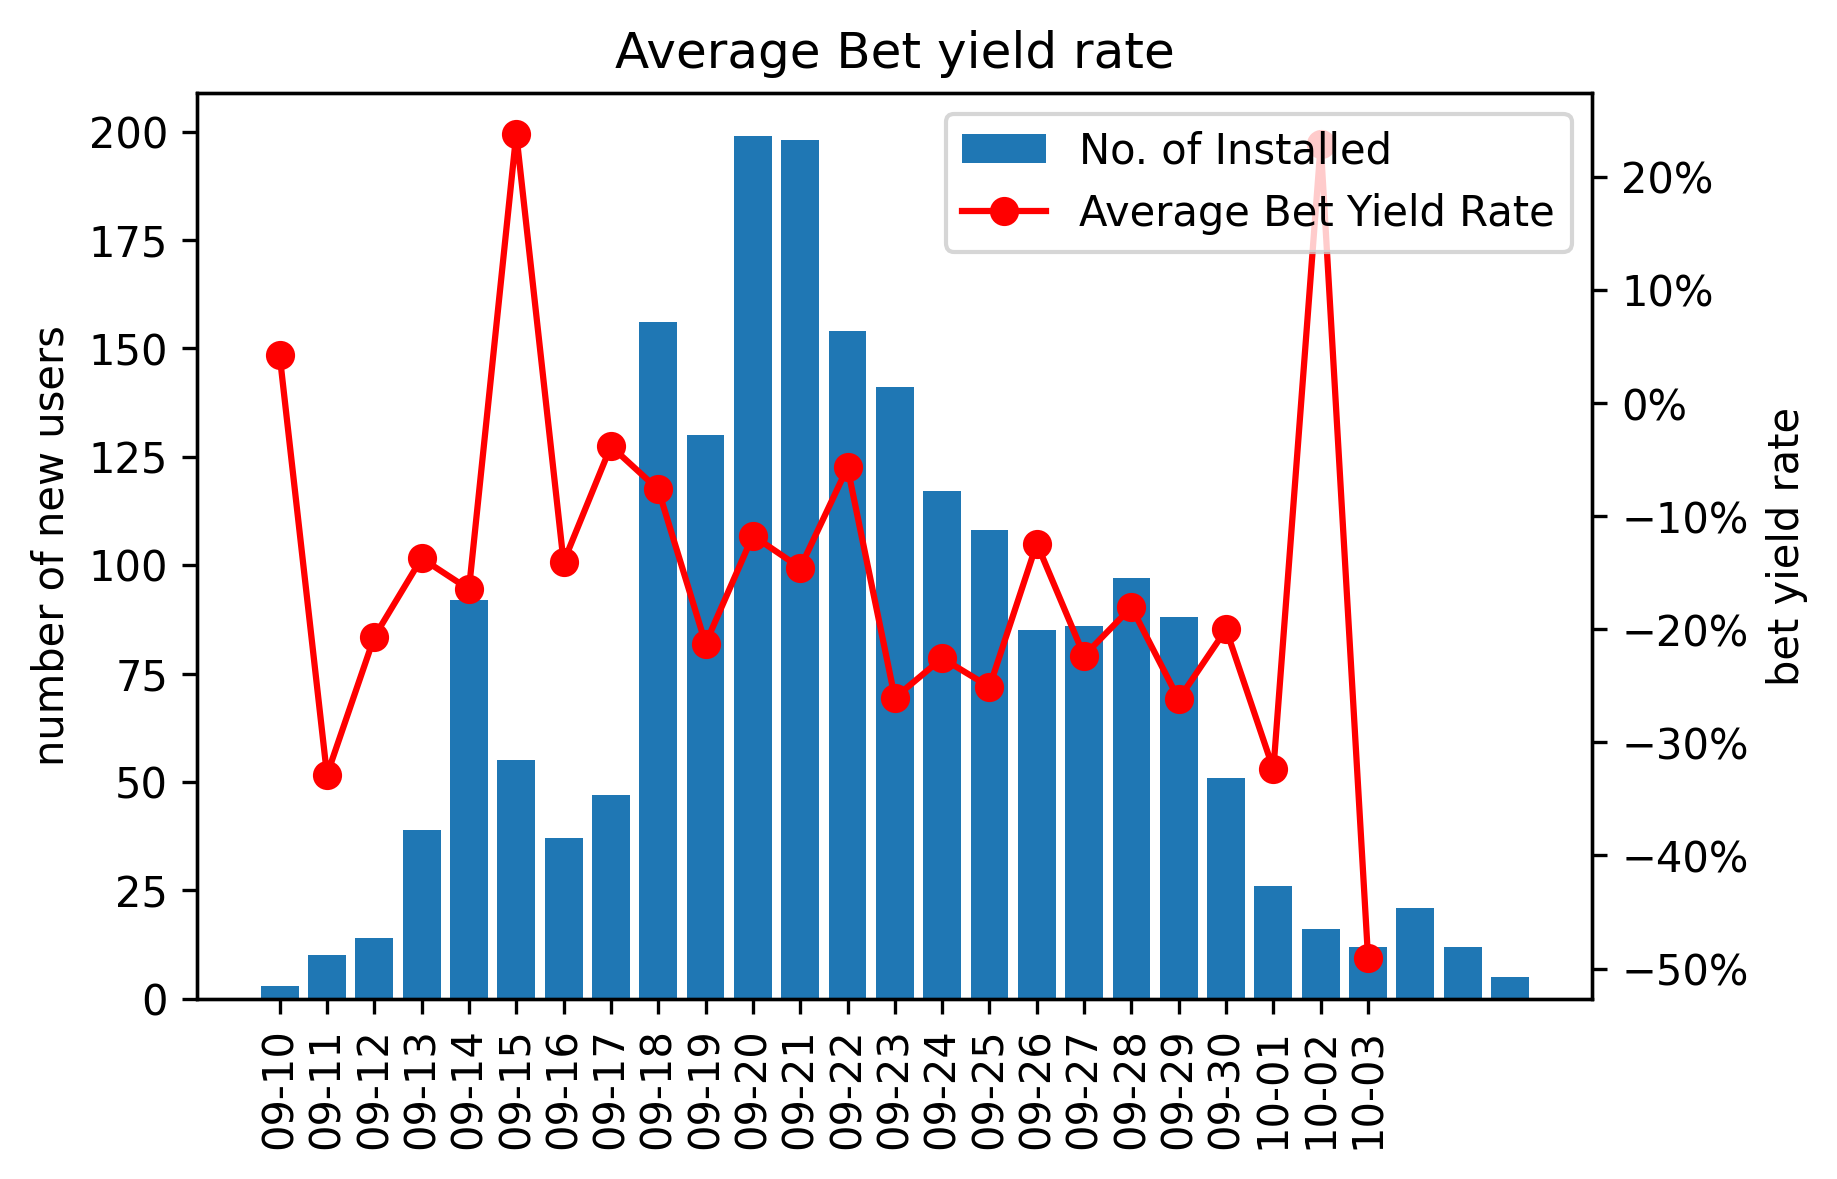

In [12]:
sql="""
SELECT
    STRFTIME('%m-%d', "install date") AS install_date,
    AVG("Bet yield rate") as "average bet yield rate"
FROM dataset
WHERE "install date"<'2014-10-04'
GROUP BY "install date" 
ORDER BY "install date"
"""
temp_df_3=pandasql.sqldf(sql)

fig, ax1 = plt.subplots()
ax1.bar(x=temp_df_1['install_date'],height=temp_df_1['install_quantity'],label='No. of Installed')
ax2 = ax1.twinx()
ax2.plot(temp_df_3['install_date'],temp_df_3['average bet yield rate'],'o-',color='red',label='Average Bet Yield Rate')

plt.setp(ax1.xaxis.get_majorticklabels(),rotation=90)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax1.set_ylabel("number of new users")
ax2.set_ylabel("bet yield rate")
plt.title("Average Bet yield rate")
fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

## No. of Spins

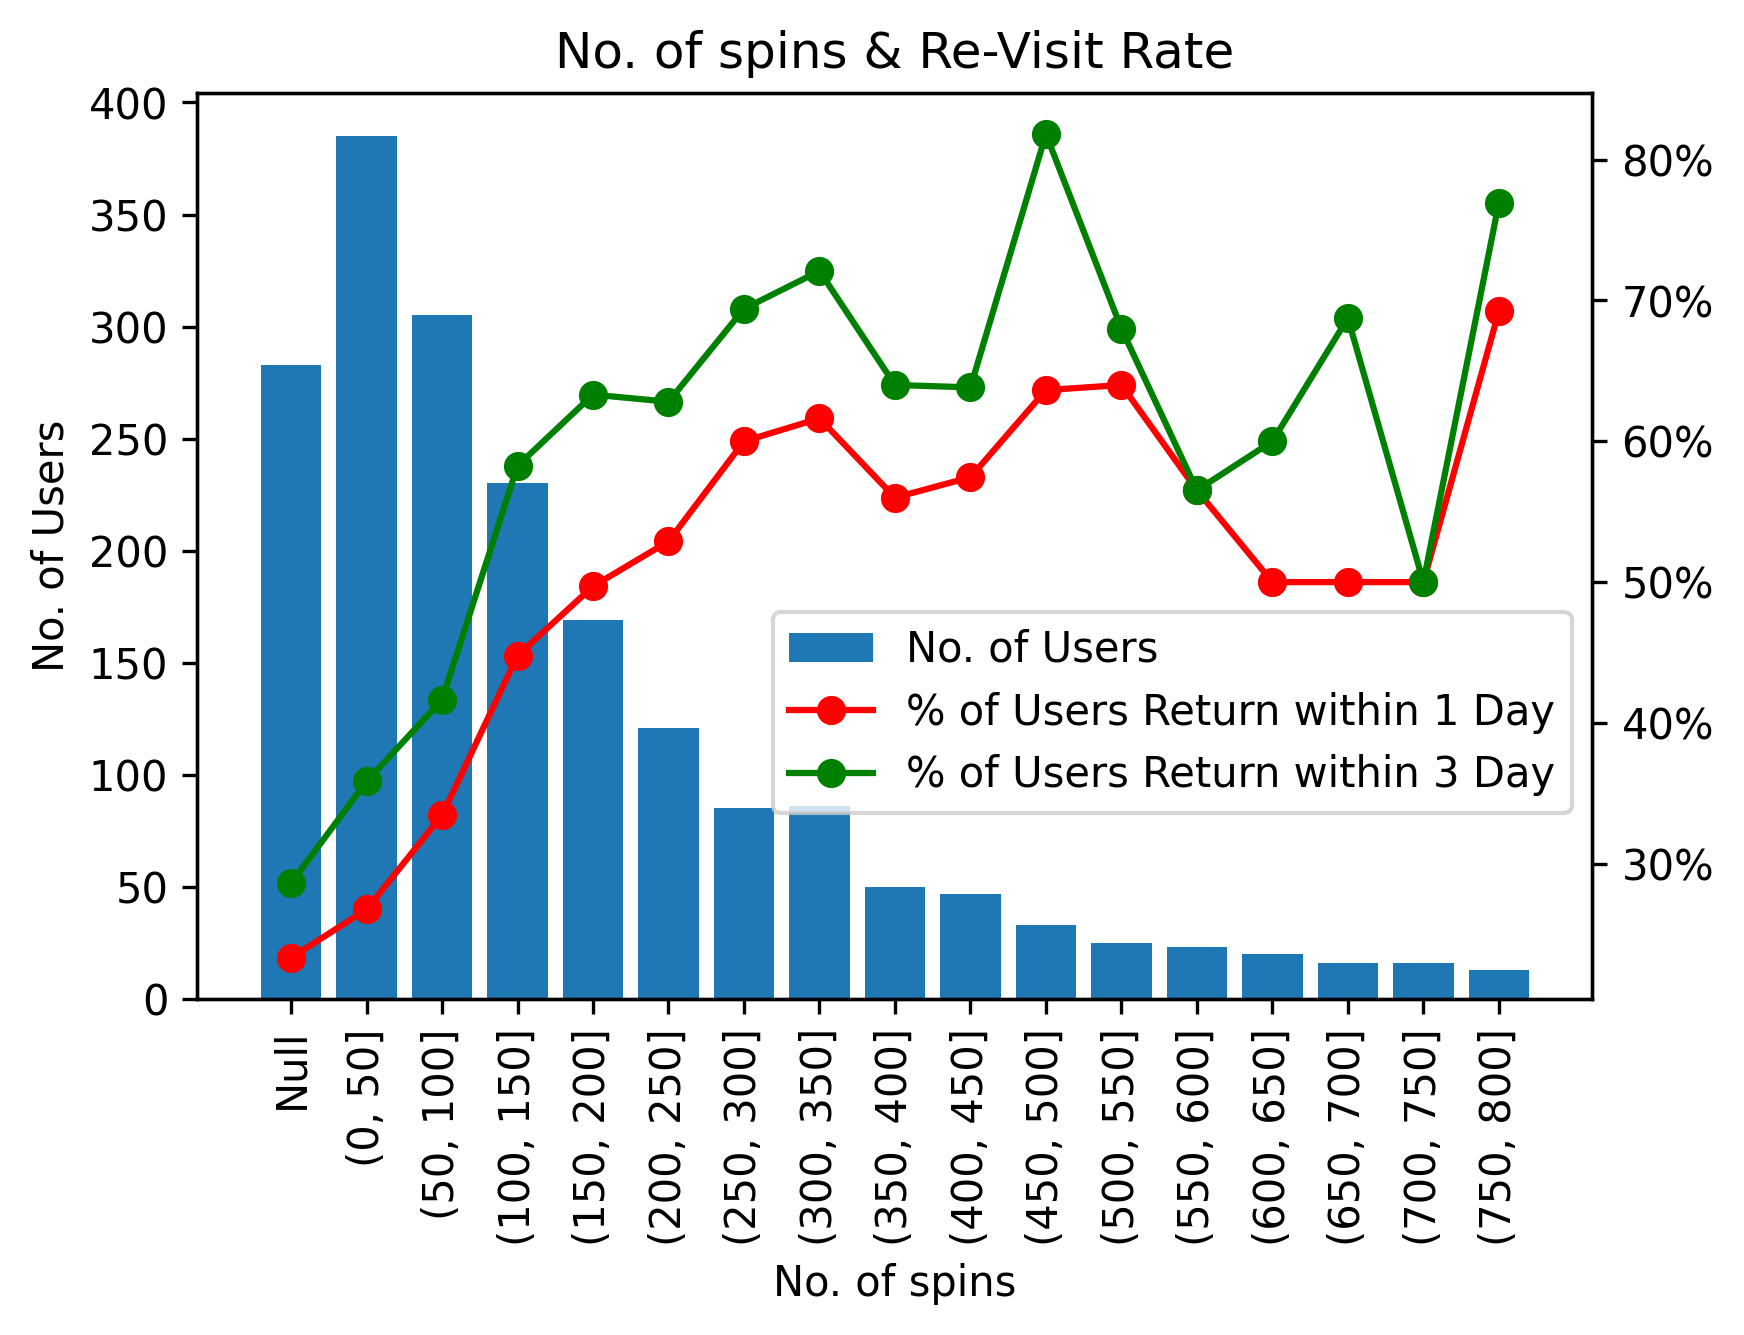

In [13]:
data=dataset[['No. of spins',"days before second visit"]].replace(np.nan,0)
data['No. of spins_label_left']=pd.cut(dataset['No. of spins'],bins=[i for i in range(0,3774+50,50)]).apply(lambda x:int(x.left))
data['No. of spins_label_right']=pd.cut(dataset['No. of spins'],bins=[i for i in range(0,3774+50,50)]).apply(lambda x:int(x.right))
data['No. of spins_label']=pd.cut(dataset['No. of spins'],bins=[i for i in range(0,3774+50,50)]).apply(str)

sql="""
SELECT 
    --"No. of spins_label_left",
    --"No. of spins_label_right",
    "No. of spins_label",
    COUNT(*) as "No. of Users",
    COUNT(CASE WHEN "days before second visit" IN (1) THEN 1 ELSE NULL END),
    COUNT(CASE WHEN "days before second visit" IN (1, 2, 3) THEN 1 ELSE NULL END),
    CAST(COUNT(CASE WHEN "days before second visit" IN (1) THEN 1 ELSE NULL END) AS FLOAT)/COUNT(*) AS "% of Users Return within 1 Day",
    CAST(COUNT(CASE WHEN "days before second visit" IN (1, 2, 3) THEN 1 ELSE NULL END) AS FLOAT)/COUNT(*) AS "% of Users Return within 3 Day"

FROM data
GROUP BY "No. of spins_label_left","No. of spins_label_right", "No. of spins_label"
HAVING COUNT(*)>10
ORDER BY CAST("No. of spins_label_left" AS INT)
"""
temp_df_5=pandasql.sqldf(sql)

fig, ax1 = plt.subplots()
ax1.bar(x=[str(i) for i in range(len(temp_df_5))],height=temp_df_5['No. of Users'],label='No. of Users')
ax2 = ax1.twinx()
ax2.plot([str(i) for i in range(len(temp_df_5))],temp_df_5['% of Users Return within 1 Day'],'o-',color='red',label='% of Users Return within 1 Day')
ax2.plot([str(i) for i in range(len(temp_df_5))],temp_df_5['% of Users Return within 3 Day'],'o-',color='green',label='% of Users Return within 3 Day')
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax1.set_xticklabels(list(temp_df_5["No. of spins_label"].fillna(value="Null")))
plt.setp(ax1.xaxis.get_majorticklabels(),rotation=90)
ax1.set_ylabel("No. of Users")
ax1.set_xlabel("No. of spins")
plt.title("No. of spins & Re-Visit Rate")
fig.legend(bbox_to_anchor=(1,0.45), bbox_transform=ax1.transAxes)
plt.show()

## Average spins per session

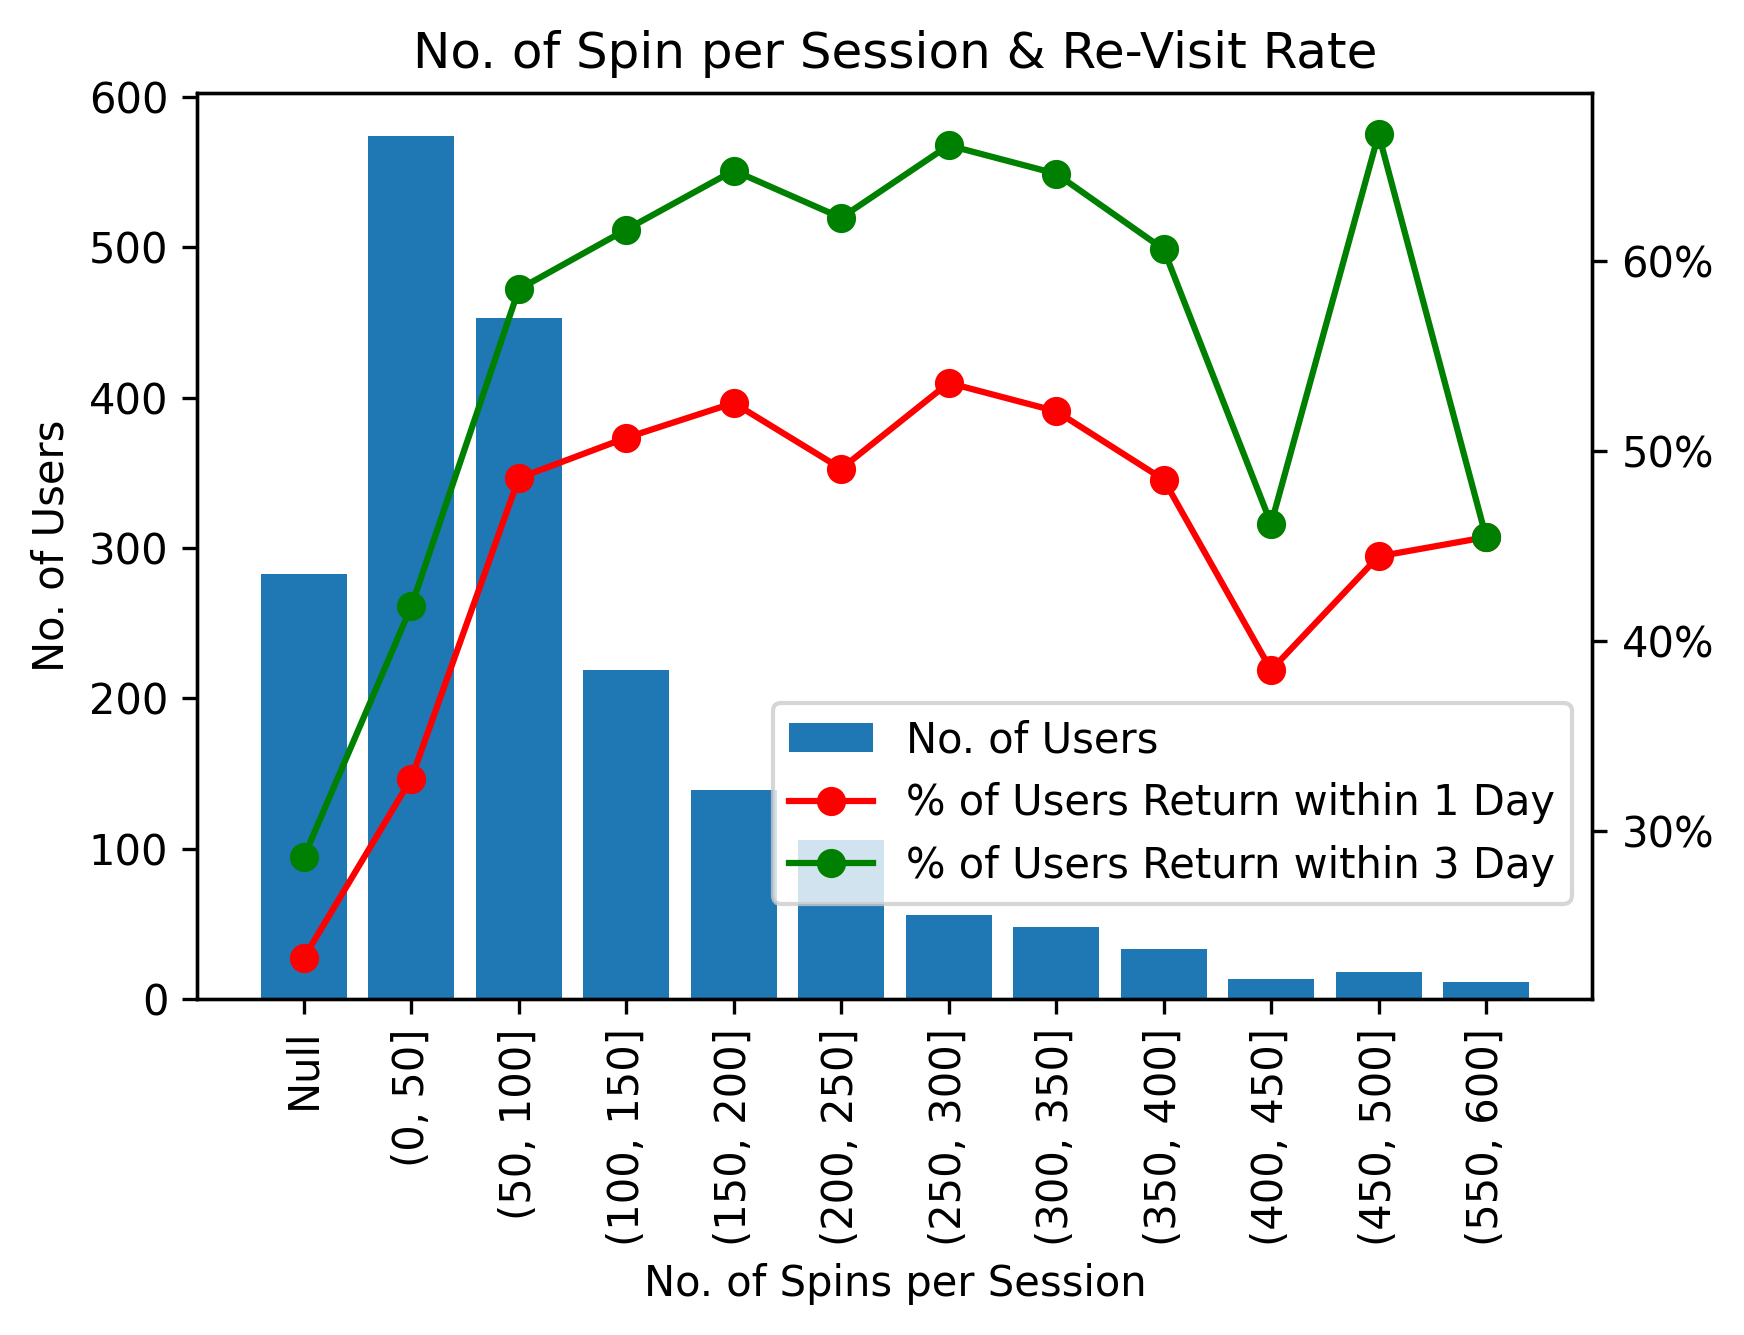

In [14]:
dataset['Average spins per session']=dataset['No. of spins']/dataset['No. of sessions']
data=dataset[['Average spins per session',"days before second visit"]].replace(np.nan,0)
data['Average spins per session_label_left']=pd.cut(dataset['Average spins per session'],bins=[i for i in range(0,3774+50,50)]).apply(lambda x:int(x.left))
data['Average spins per session_label_right']=pd.cut(dataset['Average spins per session'],bins=[i for i in range(0,3774+50,50)]).apply(lambda x:int(x.right))
data['Average spins per session_label']=pd.cut(dataset['Average spins per session'],bins=[i for i in range(0,3774+50,50)]).apply(str)
sql="""
SELECT 
    --"Average spins per session_label_left",
    --"Average spins per session_label_right",
    "Average spins per session_label",
    COUNT(*) AS "No. of Users",
    COUNT(CASE WHEN "days before second visit" IN (1) THEN 1 ELSE NULL END),
    COUNT(CASE WHEN "days before second visit" IN (1, 2, 3) THEN 1 ELSE NULL END),
    CAST(COUNT(CASE WHEN "days before second visit" IN (1) THEN 1 ELSE NULL END) AS FLOAT)/COUNT(*) AS "% of Users Return within 1 Day",
    CAST(COUNT(CASE WHEN "days before second visit" IN (1, 2, 3) THEN 1 ELSE NULL END) AS FLOAT)/COUNT(*) AS "% of Users Return within 3 Day"

FROM data
GROUP BY "Average spins per session_label_left","Average spins per session_label_right","Average spins per session_label"
HAVING COUNT(*)>10
ORDER BY CAST("Average spins per session_label_left" AS INT)
"""
temp_df_6=pandasql.sqldf(sql)

fig, ax1 = plt.subplots()
ax1.bar(x=[str(i) for i in range(len(temp_df_6))],height=temp_df_6['No. of Users'],label='No. of Users')
ax2 = ax1.twinx()
ax2.plot([str(i) for i in range(len(temp_df_6))],temp_df_6['% of Users Return within 1 Day'],'o-',color='red',label='% of Users Return within 1 Day')
ax2.plot([str(i) for i in range(len(temp_df_6))],temp_df_6['% of Users Return within 3 Day'],'o-',color='green',label='% of Users Return within 3 Day')
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax1.set_xticklabels(list(temp_df_6["Average spins per session_label"].fillna(value="Null")))
plt.setp(ax1.xaxis.get_majorticklabels(),rotation=90)
ax1.set_ylabel("No. of Users")
ax1.set_xlabel("No. of Spins per Session")
plt.title("No. of Spin per Session & Re-Visit Rate")
fig.legend(bbox_to_anchor=(1,0.35), bbox_transform=ax1.transAxes)
plt.show()

## Coin Balance before Bet

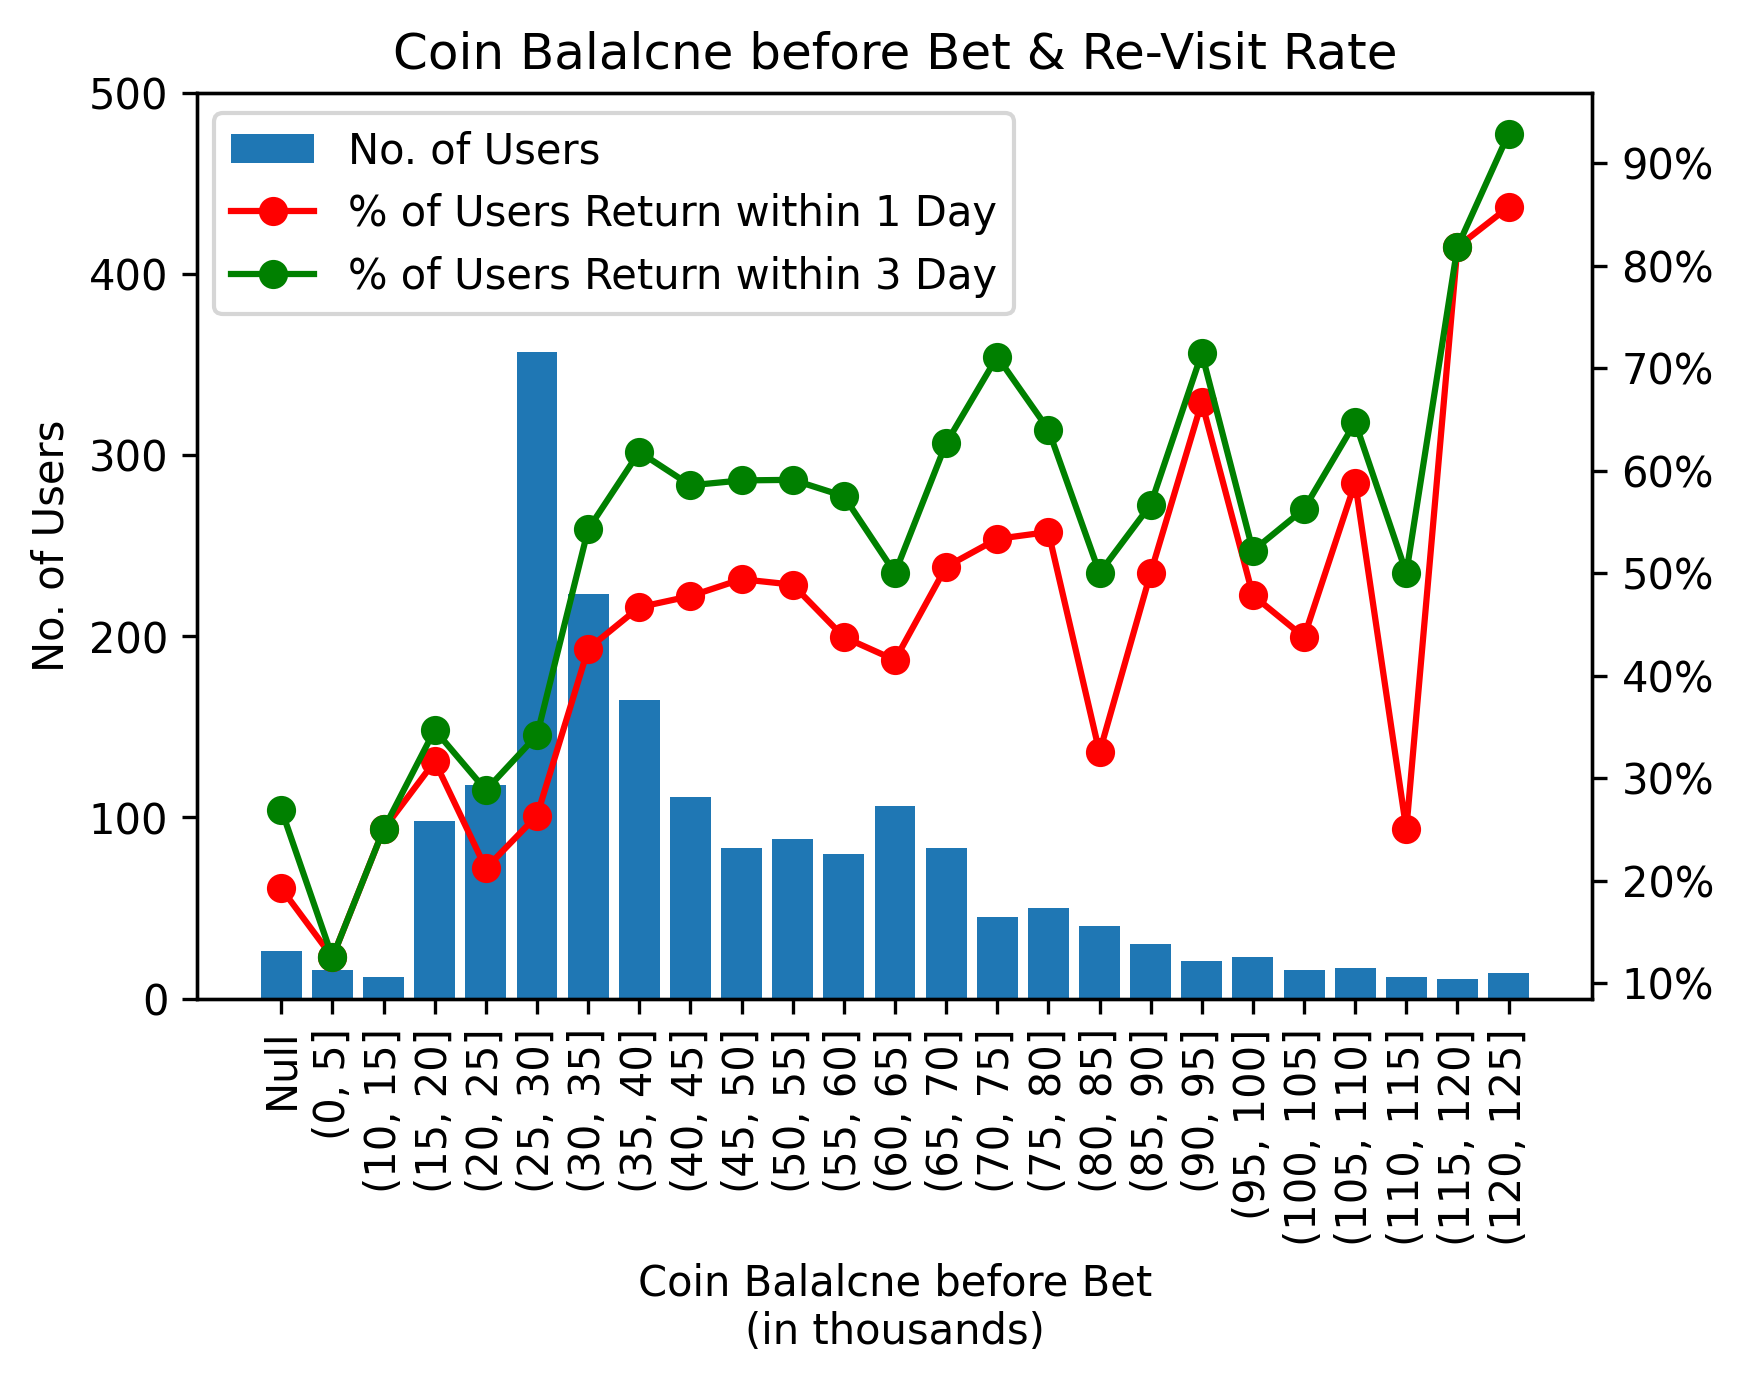

In [15]:
dataset["Total coin earn"]=dataset['Total coin wins']-dataset['Total coin bets']
dataset["coin balance before bet"]=dataset["coin balance"].replace(np.nan,0)-dataset["Total coin earn"].replace(np.nan,0)
data=dataset[["coin balance before bet","days before second visit"]].fillna(0)
data['label_left']=pd.cut(dataset['coin balance before bet'],bins=[i for i in range(0,6006350+5000,5000)]).apply(lambda x:int(x.left))
data['label_right']=pd.cut(dataset['coin balance before bet'],bins=[i for i in range(0,6006350+5000,5000)]).apply(lambda x:int(x.right))
data['label']=pd.cut(dataset['coin balance before bet'],bins=[i for i in range(0,6006350+5000,5000)]).apply(str)

sql="""
SELECT 
    --"Average spins per session_label_left",
    --"Average spins per session_label_right",
    "label",
    COUNT(*) AS "No. of Users",
    COUNT(CASE WHEN "days before second visit" IN (1) THEN 1 ELSE NULL END),
    COUNT(CASE WHEN "days before second visit" IN (1, 2, 3) THEN 1 ELSE NULL END),
    CAST(COUNT(CASE WHEN "days before second visit" IN (1) THEN 1 ELSE NULL END) AS FLOAT)/COUNT(*) AS "% of Users Return within 1 Day",
    CAST(COUNT(CASE WHEN "days before second visit" IN (1, 2, 3) THEN 1 ELSE NULL END) AS FLOAT)/COUNT(*) AS "% of Users Return within 3 Day"
FROM data
GROUP BY "label_left","label_right","label"
HAVING COUNT(*)>10
ORDER BY CAST("label_left" AS INT)
"""
temp_df_7=pandasql.sqldf(sql)
# plt.bar(x=range(len(temp_df_7)),height=temp_df_7['No. of Users'])
# temp_df_7

fig, ax1 = plt.subplots()
ax1.bar(x=[str(i) for i in range(len(temp_df_7))],height=temp_df_7['No. of Users'],label='No. of Users')
ax2 = ax1.twinx()
ax2.plot([str(i) for i in range(len(temp_df_7))],temp_df_7['% of Users Return within 1 Day'],'o-',color='red',label='% of Users Return within 1 Day')
ax2.plot([str(i) for i in range(len(temp_df_7))],temp_df_7['% of Users Return within 3 Day'],'o-',color='green',label='% of Users Return within 3 Day')
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

label=temp_df_7["label"].fillna(value="Null")
label=label.str.replace("(","")
label=label.str.replace("]","")
label=label.str.split(",")
label=label.apply(lambda x:"("+str(int(int(x[0])/1000))+", "+str(int(int(x[1])/1000))+"]" if len(x)==2 else x[0])
label=label.to_list()

ax1.set_xticklabels(label)
plt.setp(ax1.xaxis.get_majorticklabels(),rotation=90)
ax1.set_ylabel("No. of Users")
ax1.set_xlabel("Coin Balalcne before Bet\n(in thousands)")
ax1.set_ylim([0,500])
plt.title("Coin Balalcne before Bet & Re-Visit Rate")
fig.legend(bbox_to_anchor=(0.6,1), bbox_transform=ax1.transAxes)
plt.show()

# Modeling

## Feature Engineering

In [16]:
dataset['Average bet amount per spin']=dataset['Total coin bets']/dataset['No. of spins']
dataset['Average spins per session']=dataset['No. of spins']/dataset['No. of sessions']
dataset['Bet yield rate']=dataset['Total coin wins']/dataset['Total coin bets']-1
dataset["install day of week"]=dataset['install date'].apply(lambda x:x.strftime('%w'))
dataset["Total coin earn"]=dataset['Total coin wins']-dataset['Total coin bets']
dataset["coin balance before bet"]=dataset["coin balance"].replace(np.nan,0)-dataset["Total coin earn"].replace(np.nan,0)
dataset["ROI"]=dataset["Total coin earn"]/(dataset["coin balance"]-dataset["Total coin earn"])
one_hot=pd.get_dummies(dataset["install day of week"], prefix='install DOW')
dataset=pd.concat([dataset,one_hot],axis=1)
dataset["Is come back another day"]=dataset['days before second visit'].apply(lambda x:1 if x==1 else 0)

In [17]:
dataset.columns

Index(['playerid', 'install date', 'current level', 'No. of sessions',
       'coin balance', 'No. of spins', 'days before second visit',
       'Total coin wins', 'Total coin bets', 'Bet yield rate',
       'Average spins per session', 'Total coin earn',
       'coin balance before bet', 'Average bet amount per spin',
       'install day of week', 'ROI', 'install DOW_0', 'install DOW_1',
       'install DOW_2', 'install DOW_3', 'install DOW_4', 'install DOW_5',
       'install DOW_6', 'Is come back another day'],
      dtype='object')

## Feature Selection
### exclude the data where install date = 2014-10-06
### exclude feature "Current level" to avoid data leakage

In [18]:
model_df=dataset[dataset['install date']!="2014-10-06"][[col for col in dataset.columns if col not in ("current level","days before second visit")]]
model_df.reset_index
model_df.columns

Index(['playerid', 'install date', 'No. of sessions', 'coin balance',
       'No. of spins', 'Total coin wins', 'Total coin bets', 'Bet yield rate',
       'Average spins per session', 'Total coin earn',
       'coin balance before bet', 'Average bet amount per spin',
       'install day of week', 'ROI', 'install DOW_0', 'install DOW_1',
       'install DOW_2', 'install DOW_3', 'install DOW_4', 'install DOW_5',
       'install DOW_6', 'Is come back another day'],
      dtype='object')

## Logistic regression

In [19]:
#missing value
x=model_df[['No. of sessions', 'coin balance',"No. of spins",
       'Total coin wins', 'Total coin bets', 'Bet yield rate',
       'Average bet amount per spin', 'Average spins per session', 'Total coin earn', 'ROI','coin balance before bet',
        'install DOW_0','install DOW_1', 'install DOW_2', 'install DOW_3', 'install DOW_4',
       'install DOW_5', 'install DOW_6'
           ]]
imputer = KNNImputer(n_neighbors=10, weights="uniform")
x2=pd.DataFrame(imputer.fit_transform(x))
x_norm = (x2 - x2.min()) / (x2.max() - x2.min())
x_norm.columns=x.columns

#define input
x=x_norm
y=model_df['Is come back another day']

#train model
lr = LogisticRegression(penalty='l2',random_state=1) #use L2 regularization to avoid overfitting
lr.fit(x, y)
ypred = lr.predict(x)


In [20]:
#evaluate model
print("Confustion Matrix:\n",metrics.confusion_matrix(y,ypred))
print("precision_score: {}%".format(round(metrics.precision_score(y,ypred)*100,1)))
print("recall_score: {}%".format(round(metrics.recall_score(y,ypred)*100,1)))
print("accuracy_score: {}%".format(round(metrics.accuracy_score(y,ypred)*100,1)))

Confustion Matrix:
 [[1113   64]
 [ 697  120]]
precision_score: 65.2%
recall_score: 14.7%
accuracy_score: 61.8%


In [21]:
#feature importance
temp_data=pd.DataFrame(zip(list(x.columns),list(lr.coef_[0])))
temp_data.columns=["features","coefficient"]
sql="""
SELECT * FROM temp_data
ORDER BY ABS("coefficient") DESC
LIMIT 5
"""
pandasql.sqldf(sql)

,features,coefficient
0,No. of spins,3.676256
1,No. of sessions,2.703804
2,ROI,0.810488
3,Bet yield rate,0.680844
4,Average spins per session,-0.457461


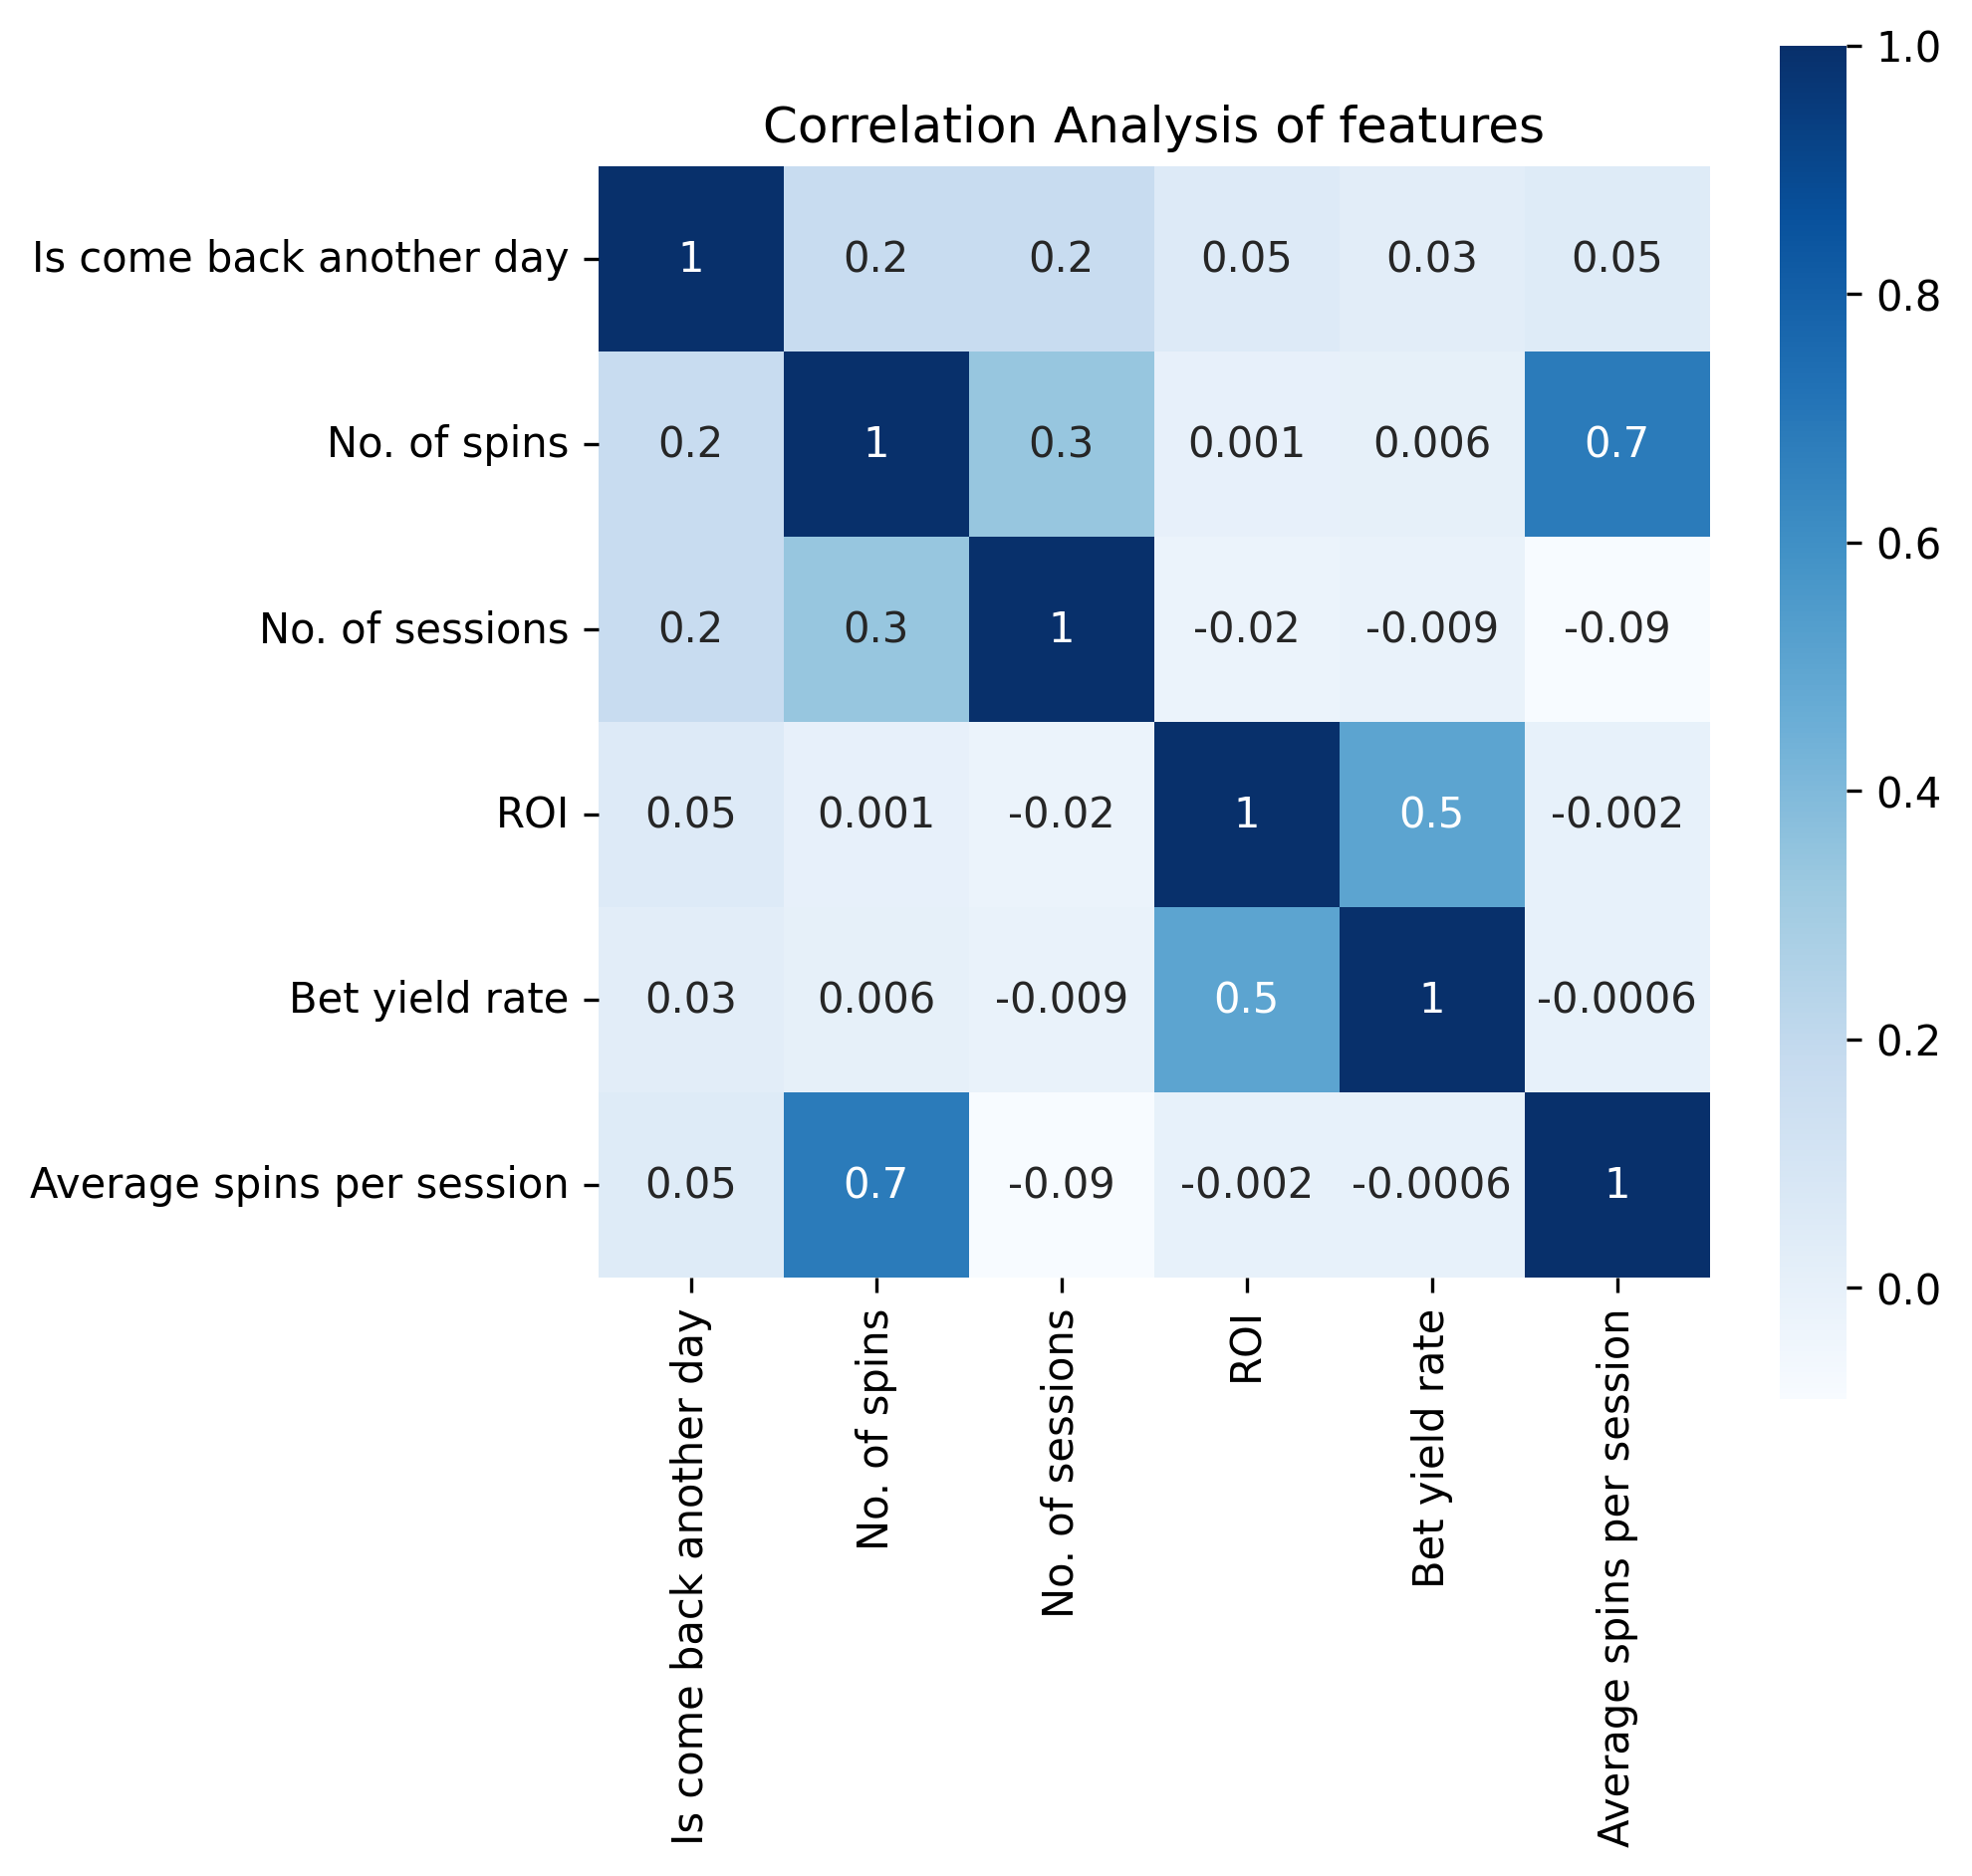

In [22]:
df_coor=model_df[['Is come back another day',"No. of spins","No. of sessions","ROI","Bet yield rate","Average spins per session"]].corr()
plt.subplots(figsize=(6,6))
fig=sns.heatmap(df_coor,annot=True, vmax=1, square=True, cmap="Blues", fmt='.1g')
plt.title("Correlation Analysis of features")
plt.show()

## Random Forest

In [23]:
#define input
x=model_df[['No. of sessions', 'coin balance',
       'No. of spins', 'Total coin wins', 'Total coin bets', 'Bet yield rate',
       'Average bet amount per spin', 'Average spins per session', 'Total coin earn', 'ROI','coin balance before bet',
       'install DOW_0','install DOW_1', 'install DOW_2', 'install DOW_3', 'install DOW_4',
       'install DOW_5', 'install DOW_6']].replace(np.nan, -1)
y=model_df['Is come back another day']

#train model
rfc = RandomForestClassifier(100,ccp_alpha=0.004,random_state=3)
rfc = rfc.fit(x,y)
ypred = rfc.predict(x)

In [24]:
#evaluate model
print("Confustion Matrix:\n",metrics.confusion_matrix(y,ypred))
print("precision_score: {}%".format(round(metrics.precision_score(y,ypred)*100,1)))
print("recall_score: {}%".format(round(metrics.recall_score(y,ypred)*100,1)))
print("accuracy_score: {}%".format(round(metrics.accuracy_score(y,ypred)*100,1)))

Confustion Matrix:
 [[968 209]
 [439 378]]
precision_score: 64.4%
recall_score: 46.3%
accuracy_score: 67.5%


In [25]:
#feature importance
temp_data=pd.DataFrame(zip(list(x.columns),rfc.feature_importances_))
temp_data.columns=["features","VIM"]
sql="""
SELECT * FROM temp_data
ORDER BY "VIM" DESC
LIMIT 5
"""
pandasql.sqldf(sql)

,features,VIM
0,No. of sessions,0.244714
1,No. of spins,0.195443
2,Total coin bets,0.144737
3,Total coin wins,0.088844
4,coin balance,0.080992


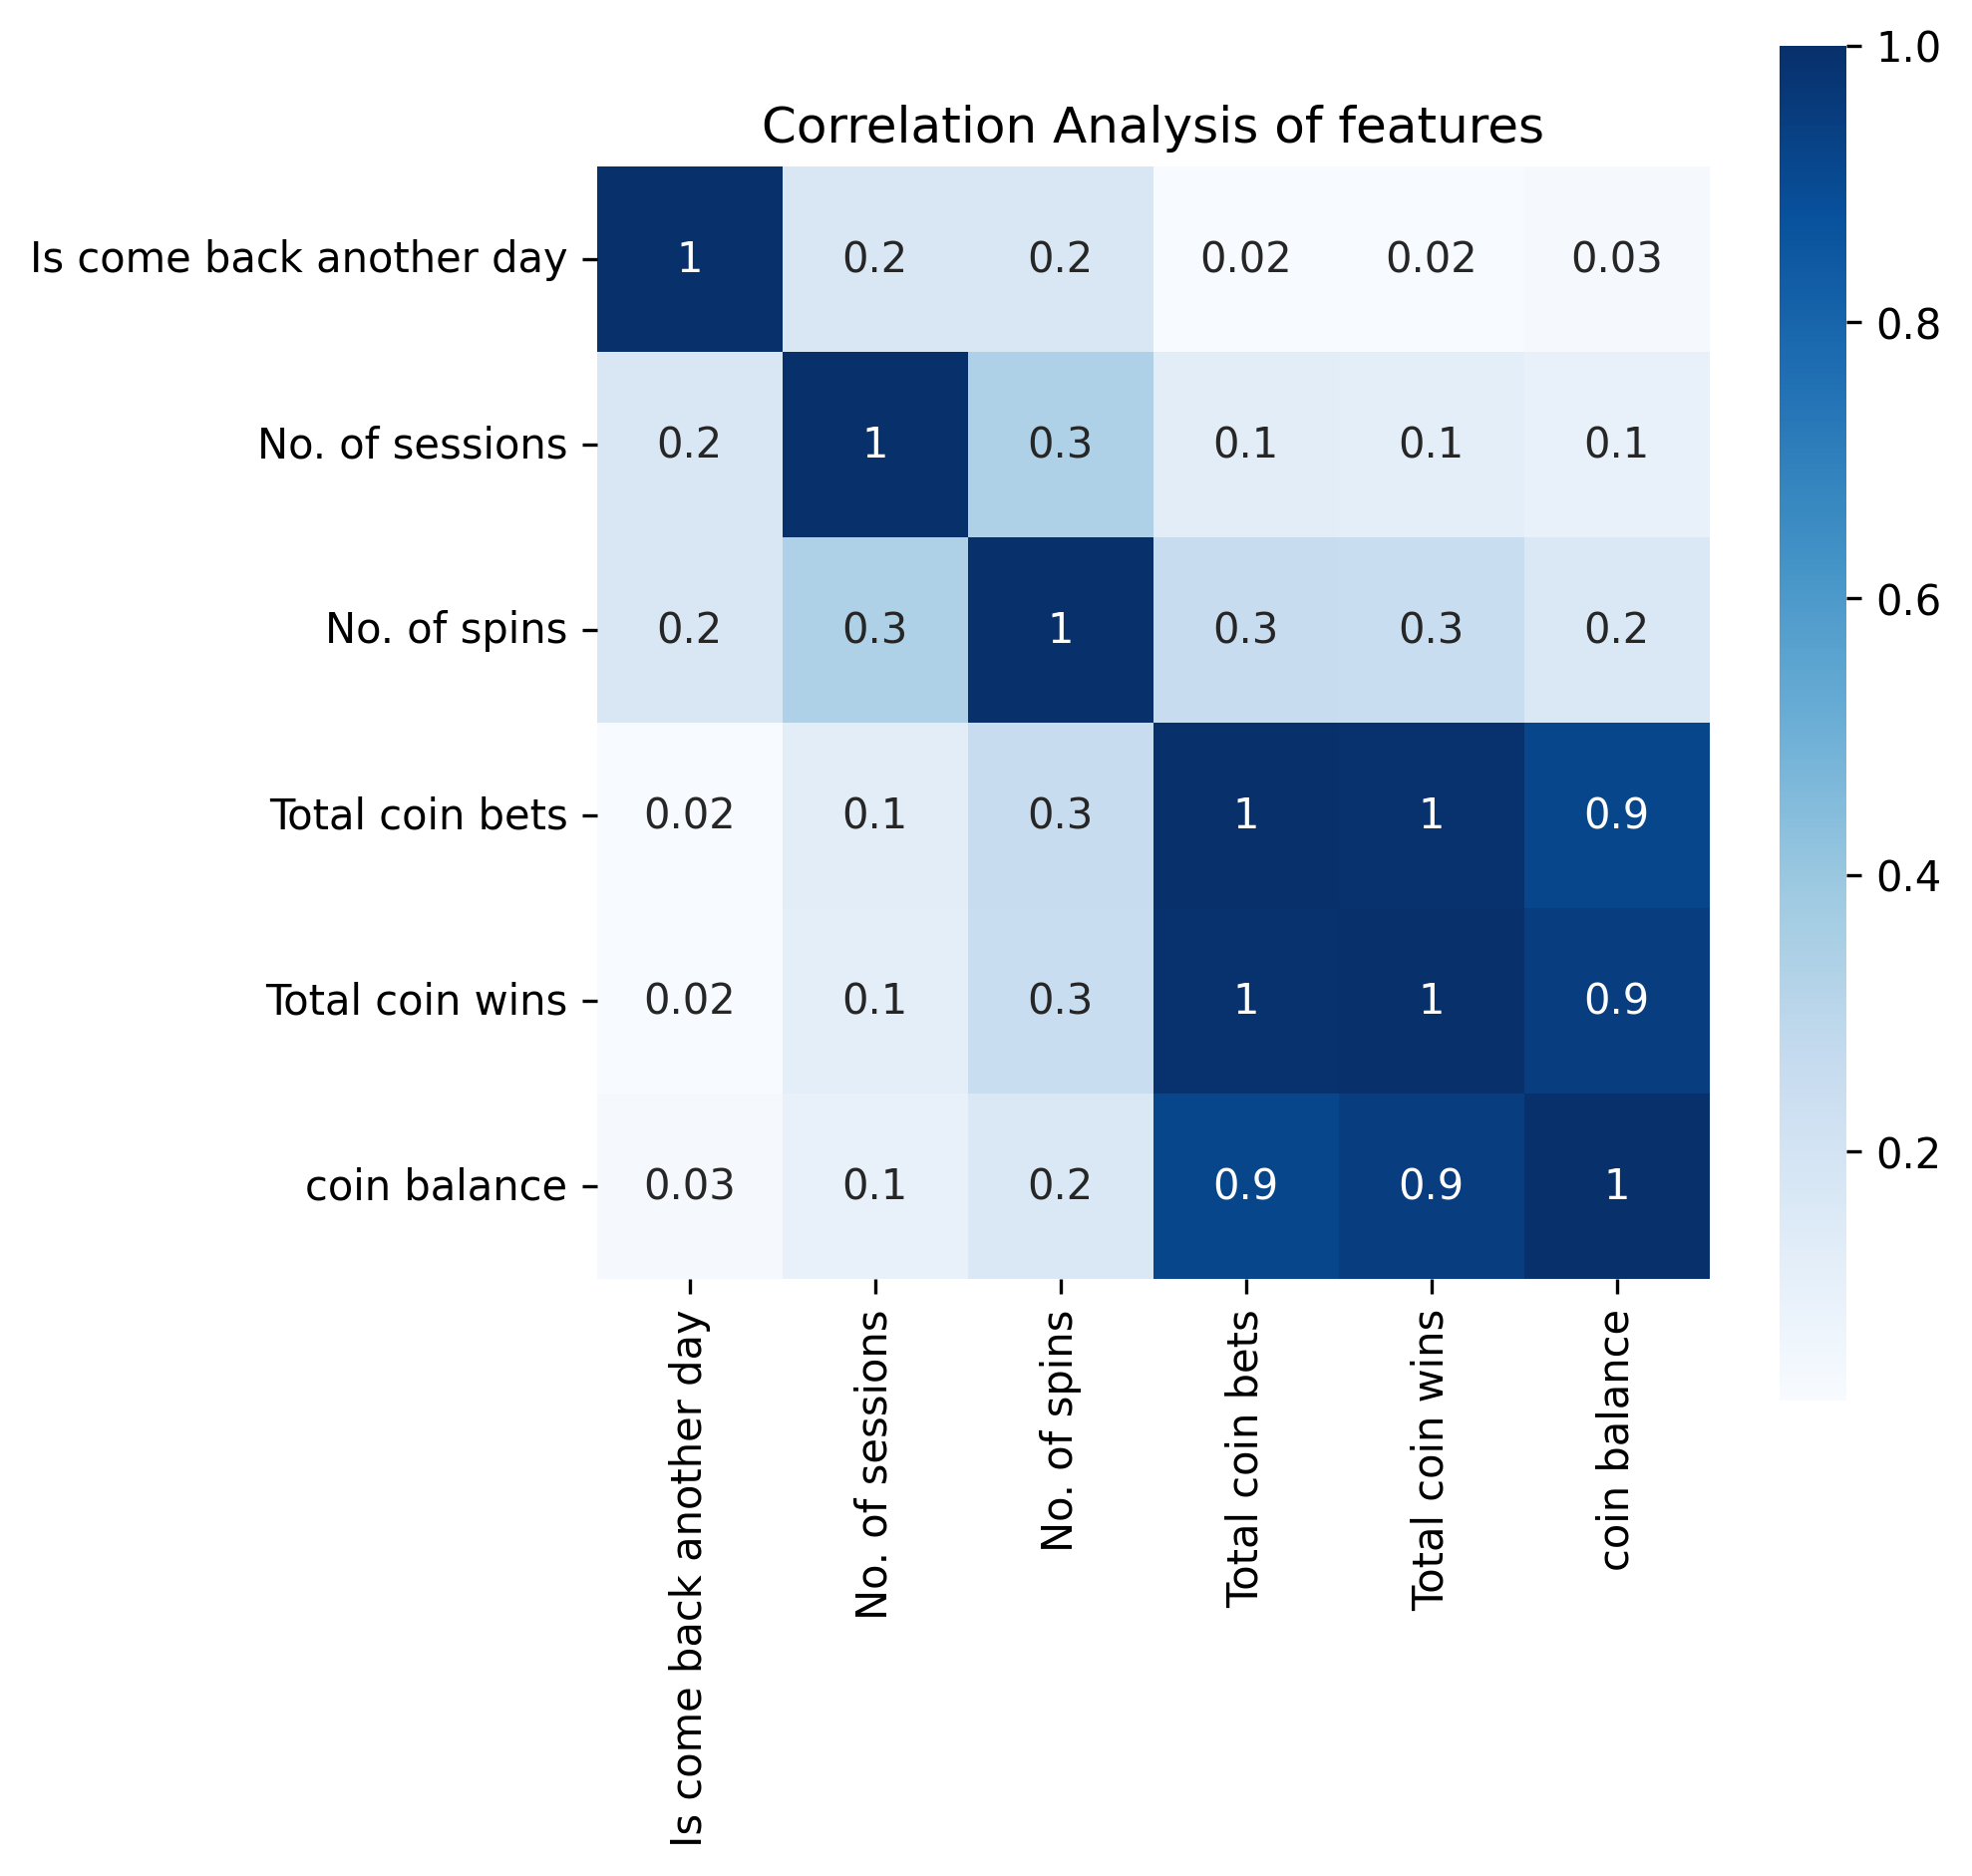

In [26]:
df_coor=model_df[['Is come back another day',"No. of sessions","No. of spins","Total coin bets","Total coin wins","coin balance"]].corr()
plt.subplots(figsize=(6,6))
fig=sns.heatmap(df_coor,annot=True, vmax=1, square=True, cmap="Blues", fmt='.1g')
plt.title("Correlation Analysis of features")
plt.show()